# Librerias

In [1]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from sklearn.utils import class_weight
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

from sklearn.metrics import confusion_matrix,accuracy_score
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
from random import shuffle,seed
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval

Using TensorFlow backend.


# Funciones

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.preprocessing import normalize
import time
import matplotlib.pyplot as plt

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Precision"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    #dic_return["Recall"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred, labels=[0,1])
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return


def calculate_median_abs_err(real, pred): 
    if len(real.shape) > 1:
        return np.mean([median_absolute_error(real[:,d],pred[:,d]) for d in range(real.shape[1])])   
    else:
        return median_absolute_error(real,pred)
    
def calculate_mean_abs_perce_err(real, pred):
    diff = np.abs((real - pred) / np.clip(np.abs(real), 1e-7, None))
    return 100. * np.mean(diff) #sin *100 es "fractional"

def calculate_Rmean_squar_log_err(real, pred):
    first_log = np.log(np.clip(pred, 1e-7, None) + 1.)
    second_log = np.log(np.clip(real, 1e-7, None) + 1.)
    return np.sqrt(np.mean(np.square(first_log - second_log)))

def evaluate_metadata(real, pred, plot=False):
    dic_res = {}
    dic_res["MSE"] = mean_squared_error(real, pred)
    dic_res["MAE"] = mean_absolute_error(real, pred)
    dic_res["MeAE"] = calculate_median_abs_err(real, pred)
    dic_res["MApE"] = calculate_mean_abs_perce_err(real,pred)
    dic_res["RMSLE"] = calculate_Rmean_squar_log_err(real,pred)
    if plot:
        df = pd.DataFrame(dic_res)
        df.index = ["Real"]
        plot_df(df)
    return dic_res

def evaluate_metadata_raw(real, pred, plot=True, metadata_used=[""]):
    mse_raw = []
    mae_raw = []
    mEae_raw = []
    maPe_raw = []
    rmsle_raw = []
    for d in range(real.shape[1]):        
        dic_aux = evaluate_metadata(real[:,d], pred[:,d], plot=False)
        mse_raw.append(dic_aux["MSE"])
        mae_raw.append(dic_aux["MAE"])
        mEae_raw.append(dic_aux["MeAE"])
        maPe_raw.append(dic_aux["MApE"])
        rmsle_raw.append(dic_aux["RMSLE"])
        
    res_metadata = {}
    res_metadata["MSE"] = mse_raw
    res_metadata["MAE"] = mae_raw
    res_metadata["MeAE"] = mEae_raw
    res_metadata["MApE"] = maPe_raw
    res_metadata["RMSLE"] = rmsle_raw
    
    if plot:
        df = pd.DataFrame(res_metadata)
        df.index = metadata_used
        df.loc["Global"] = np.mean(df, axis=0)
        plot_df(df.transpose())
    res_metadata["MSE"].append(np.mean(mse_raw))
    res_metadata["MAE"].append(np.mean(mae_raw))
    res_metadata["MeAE"].append(np.mean(mEae_raw))
    res_metadata["MApE"].append(np.mean(maPe_raw))
    res_metadata["RMSLE"].append(np.mean(rmsle_raw))
    return res_metadata




def train_model(aux_model, x_train, y_train, x_val, y_val, e=25, BS=128):
    hist=aux_model.fit(x_train, y_train, batch_size=BS, epochs=e, verbose=1, validation_data=(x_val,y_val))
    plt.plot(hist.history['loss'],label="train_loss")
    plt.plot(hist.history['val_loss'],label="val_loss")
    plt.title("Model Loss BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    plt.plot(hist.history['acc'],label="Train accuracy" )
    plt.plot(hist.history['val_acc'],label="Val accuracy" )
    plt.title("Model Accuracy BCE CNN") 
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc="upper right")
    plt.show()

    predichos=aux_model.predict_classes(x_val)
    calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC')


# Cargar datos

## Generar imagenes con 3 canales

In [3]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
labels.shape

(8054,)

In [4]:
channel_1 = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u15_d15.npy')  
channel_2 = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u15_d15.npy')  
channel_3 = np.load('/work/work_teamEXOPLANET/MTF_gabo/npys/time_channel_30.npy')  

In [5]:
print(channel_1.shape)
print(channel_2.shape)
print(channel_3.shape)

(8054, 30, 30)
(8054, 30, 30)
(8054, 30, 30)


In [6]:
x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i],channel_3[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)

In [7]:
x_all.shape

(8054, 30, 30, 3)

In [8]:
'''x_all = []
for i in range(channel_1.shape[0]):
    combined_image = np.dstack((channel_1[i],channel_2[i]))
    x_all.append(combined_image)
x_all = np.asarray(x_all)'''

'x_all = []\nfor i in range(channel_1.shape[0]):\n    combined_image = np.dstack((channel_1[i],channel_2[i]))\n    x_all.append(combined_image)\nx_all = np.asarray(x_all)'

## Generar conjunto de entrenamiento y validación

In [9]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Train
1,K01009.01,Train
2,K07621.01,Test
3,K06252.01,Test
4,K00958.01,Unlabeled


In [10]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
0,K00889.01,CONFIRMED,Kepler-75 b,8.884923,169.991686,2455002.992,0.069,2.07004,16053.4,0.114,...,5332.0,4.500,-0.08,0.843,0.821,61.291,474.021,388.2,1,153
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.535940,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
7,K07622.01,FALSE POSITIVE,NaN,36.267167,155.081300,2454988.081,0.214,2.06500,627.1,0.022,...,4264.0,4.637,-0.20,0.620,0.607,3.016,7.472,10.0,1,39
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.039000,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9
10,K00992.01,CONFIRMED,Kepler-745 b,9.931463,136.491280,2454969.491,0.037,5.67800,398.6,0.018,...,5782.0,4.280,0.16,1.220,1.035,4.530,22.901,26.2,2,137


In [11]:
y_train= (df_meta_train['NExScI Disposition'].values=="CONFIRMED")*1
y_val = (df_meta_test['NExScI Disposition'].values=="CONFIRMED")*1

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)

print('y_train distribution: 0:%i   1:%i'%(counts_train[0],counts_train[1]))
print('y_val distribution:   0:%i   1:%i'%(counts_val[0],counts_val[1]))

y_train distribution: 0:2729   1:1610
y_val distribution:   0:1247   1:671


In [12]:
x_train = x_all[mask_train]
x_val = x_all[mask_test]

if x_train.shape[0] < y_train.shape[0]:
    y_train = y_train[:x_train.shape[0]]
    
print ("Objetos de entrenamiento:",x_train.shape, y_train.shape)
print ("Objetos de validación:",x_val.shape,y_val.shape)

Objetos de entrenamiento: (4339, 30, 30, 3) (4339,)
Objetos de validación: (1918, 30, 30, 3) (1918,)


## Generando class weight

In [13]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


## PCA conjunto de prueba y validación

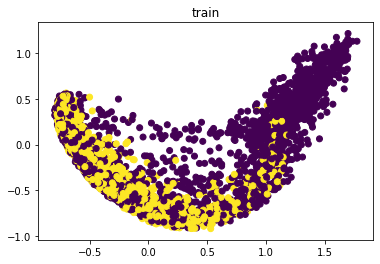

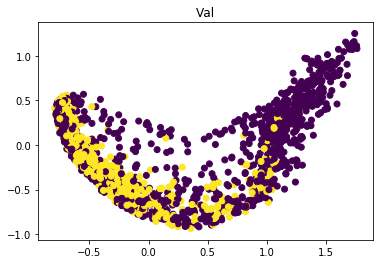

In [14]:
#nuevo test...

from sklearn.decomposition import PCA
dims_r = np.prod(x_train.shape[1:])
model = PCA(2)
plot_x = model.fit_transform(x_train.reshape([x_train.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_train, cmap='viridis') #morado es falso positivo
plt.title("train")
plt.show()

plot_x = model.transform(x_val.reshape([x_val.shape[0],dims_r]))
plt.scatter(plot_x[:,0],plot_x[:,1], c=y_val, cmap='viridis') #morado es falso positivo
plt.title("Val")
plt.show()

## Pruebas CNN utilizando loss = binary_crossentropy

In [13]:
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2700)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               691456    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 692,737
Trainable params: 692,225
Non-trainable params: 512
___________________________________________________________

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 2s 353us/step - loss: 0.7901 - acc: 0.5997 - val_loss: 4.0586 - val_acc: 0.3613
Epoch 2/25
4339/4339 [==============================] - 0s 83us/step - loss: 0.6036 - acc: 0.6601 - val_loss: 0.6350 - val_acc: 0.6319
Epoch 3/25
4339/4339 [==============================] - 0s 79us/step - loss: 0.5499 - acc: 0.6912 - val_loss: 0.7943 - val_acc: 0.5996
Epoch 4/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5399 - acc: 0.6997 - val_loss: 0.6506 - val_acc: 0.6350
Epoch 5/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5262 - acc: 0.7138 - val_loss: 0.8062 - val_acc: 0.6027
Epoch 6/25
4339/4339 [==============================] - 0s 77us/step - loss: 0.5070 - acc: 0.7223 - val_loss: 1.2468 - val_acc: 0.5422
Epoch 7/25
4339/4339 [==============================] - 0s 90us/step - loss: 0.4995 - acc: 0.7304 - val_loss: 1.4212 - val_acc: 0.5344
Epoch 

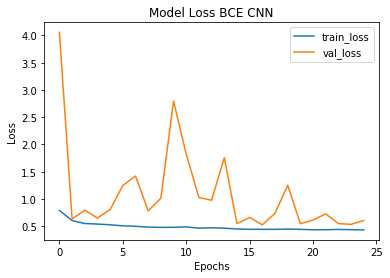

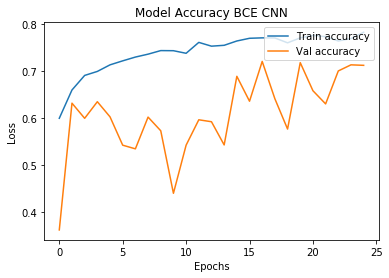

In [14]:
hist=model.fit(x_train, y_train, batch_size=128, epochs=25, verbose=1, validation_data=(x_val,y_val))

plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.702091,0.969527,0.814416,0.657007,0.589445,0.712722
Confirmed,0.806122,0.235469,0.364475,0.657007,0.589445,0.712722


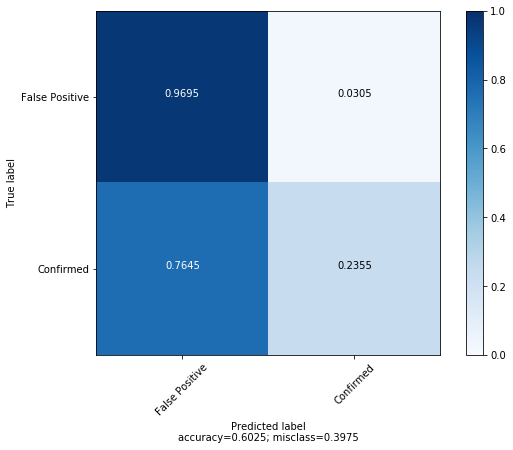

{'Precision raw': array([0.70209059, 0.80612245]), 'Recall raw': array([0.96952686, 0.23546945]), 'F1 raw': array([0.81441563, 0.3644752 ]), 'F1 weighted': 0.6570068554488301, 'F1 macro': 0.5894454150015365, 'F1 micro': 0.7127215849843588, 'Confusion Matrix': array([[1209,   38],
       [ 513,  158]])}


In [15]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val, predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

### Modelo 1

In [16]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 11, 11, 64)      

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 9s 2ms/step - loss: 0.6247 - acc: 0.6285 - val_loss: 0.5878 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 6s 1ms/step - loss: 0.5760 - acc: 0.6289 - val_loss: 0.5593 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 7s 1ms/step - loss: 0.5738 - acc: 0.6289 - val_loss: 0.5604 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5702 - acc: 0.6289 - val_loss: 0.5552 - val_acc: 0.6502
Epoch 5/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5696 - acc: 0.6289 - val_loss: 0.5499 - val_acc: 0.6502
Epoch 6/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5581 - acc: 0.6289 - val_loss: 0.5465 - val_acc: 0.6502
Epoch 7/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5478 - acc: 0.6287 - val_loss: 0.5377 - val_acc: 0.6502
Epoch 8/25
433

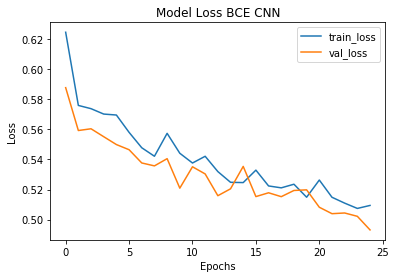

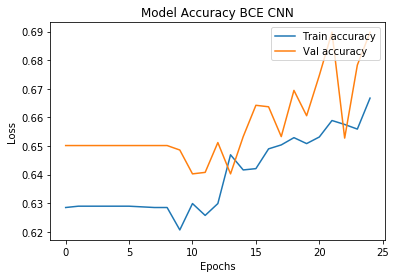

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.693587,0.936648,0.796998,0.638009,0.56977,0.689781
Confirmed,0.662393,0.230999,0.342541,0.638009,0.56977,0.689781


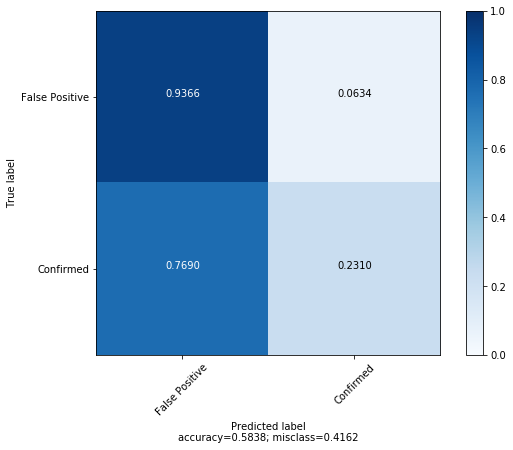

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5042 - acc: 0.6702 - val_loss: 0.5142 - val_acc: 0.6783
Epoch 2/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5049 - acc: 0.6771 - val_loss: 0.4965 - val_acc: 0.6950
Epoch 3/40
4339/4339 [==============================] - 7s 1ms/step - loss: 0.5006 - acc: 0.6771 - val_loss: 0.4971 - val_acc: 0.6893
Epoch 4/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5054 - acc: 0.6723 - val_loss: 0.4923 - val_acc: 0.6783
Epoch 5/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.5012 - acc: 0.6833 - val_loss: 0.4904 - val_acc: 0.6778
Epoch 6/40
4339/4339 [==============================] - 6s 1ms/step - loss: 0.5031 - acc: 0.6831 - val_loss: 0.4990 - val_acc: 0.6788
Epoch 7/40
4339/4339 [==============================] - 7s 2ms/step - loss: 0.4923 - acc: 0.6870 - val_loss: 0.4829 - val_acc: 0.7247
Epoch 8/40
433

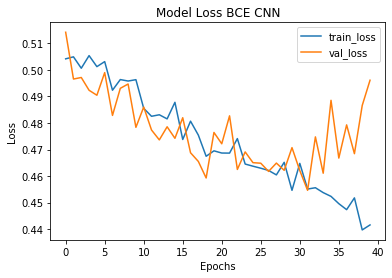

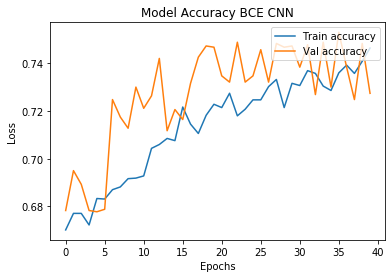

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.73385,0.910986,0.812880,0.702581,0.655239,0.72732
Confirmed,0.70000,0.385991,0.497598,0.702581,0.655239,0.72732


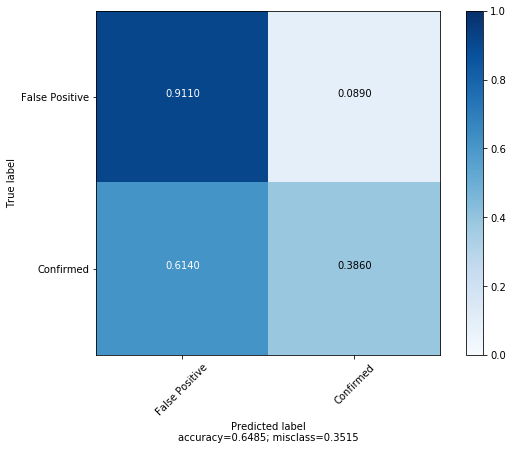

In [18]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 2

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(64, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)        

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 6s 1ms/step - loss: 0.6200 - acc: 0.6197 - val_loss: 0.5740 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 4s 862us/step - loss: 0.5738 - acc: 0.6289 - val_loss: 0.5630 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 4s 849us/step - loss: 0.5654 - acc: 0.6278 - val_loss: 0.5526 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 4s 856us/step - loss: 0.5587 - acc: 0.6377 - val_loss: 0.5439 - val_acc: 0.6288
Epoch 5/25
4339/4339 [==============================] - 4s 868us/step - loss: 0.5447 - acc: 0.6243 - val_loss: 0.5345 - val_acc: 0.6496
Epoch 6/25
4339/4339 [==============================] - 4s 875us/step - loss: 0.5479 - acc: 0.6347 - val_loss: 0.5249 - val_acc: 0.6533
Epoch 7/25
4339/4339 [==============================] - 4s 855us/step - loss: 0.5353 - acc: 0.6382 - val_loss: 0.5296 - val_acc: 0.6356
Ep

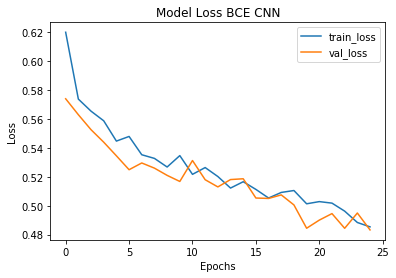

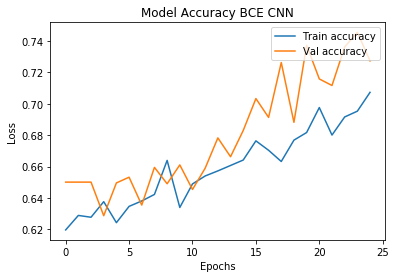

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.748285,0.874900,0.806654,0.712519,0.672116,0.72732
Confirmed,0.660870,0.453055,0.537577,0.712519,0.672116,0.72732


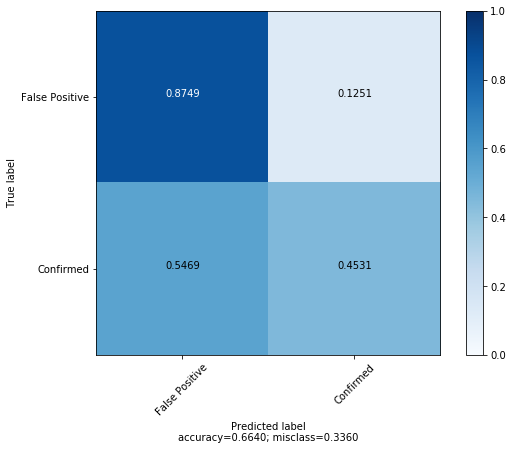

In [20]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 4s 884us/step - loss: 0.4826 - acc: 0.7089 - val_loss: 0.4675 - val_acc: 0.7487
Epoch 2/40
4339/4339 [==============================] - 4s 870us/step - loss: 0.4786 - acc: 0.7140 - val_loss: 0.4898 - val_acc: 0.7388
Epoch 3/40
4339/4339 [==============================] - 4s 856us/step - loss: 0.4760 - acc: 0.7117 - val_loss: 0.4810 - val_acc: 0.7331
Epoch 4/40
4339/4339 [==============================] - 4s 839us/step - loss: 0.4750 - acc: 0.7112 - val_loss: 0.4871 - val_acc: 0.7393
Epoch 5/40
4339/4339 [==============================] - 4s 867us/step - loss: 0.4722 - acc: 0.7211 - val_loss: 0.4710 - val_acc: 0.7377
Epoch 6/40
4339/4339 [==============================] - 4s 868us/step - loss: 0.4740 - acc: 0.7147 - val_loss: 0.4783 - val_acc: 0.7383
Epoch 7/40
4339/4339 [==============================] - 4s 858us/step - loss: 0.4663 - acc: 0.7211 - val_loss: 0.4713 - val_acc: 0.7372


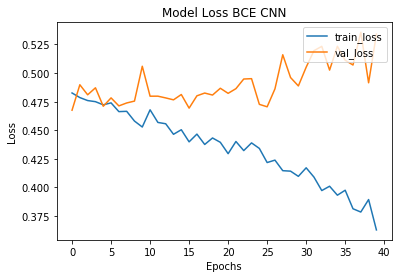

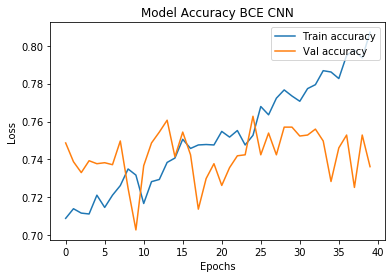

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.809008,0.777867,0.793132,0.73815,0.714551,0.736184
Confirmed,0.614743,0.658718,0.635971,0.73815,0.714551,0.736184


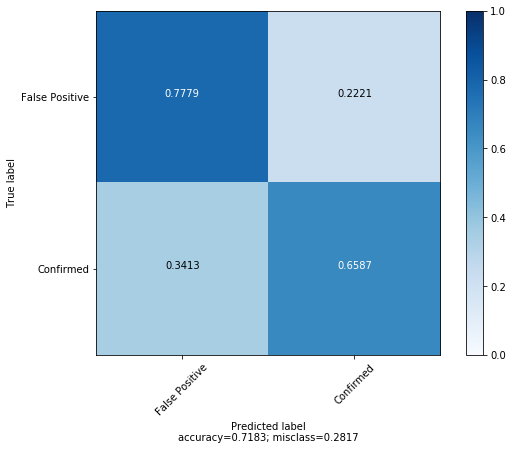

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=40) 

In [22]:
#train_model(model, x_train, y_train, x_val, y_val, e=200) 

### Modelo 3

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 128)       36992     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)        

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 4s 967us/step - loss: 0.6330 - acc: 0.6280 - val_loss: 0.5627 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 2s 550us/step - loss: 0.5679 - acc: 0.6310 - val_loss: 0.5555 - val_acc: 0.6512
Epoch 3/25
4339/4339 [==============================] - 2s 550us/step - loss: 0.5657 - acc: 0.6223 - val_loss: 0.5520 - val_acc: 0.6543
Epoch 4/25
4339/4339 [==============================] - 2s 559us/step - loss: 0.5563 - acc: 0.6216 - val_loss: 0.5420 - val_acc: 0.6283
Epoch 5/25
4339/4339 [==============================] - 2s 558us/step - loss: 0.5529 - acc: 0.6257 - val_loss: 0.5416 - val_acc: 0.6303
Epoch 6/25
4339/4339 [==============================] - 2s 557us/step - loss: 0.5388 - acc: 0.6324 - val_loss: 0.5277 - val_acc: 0.6429
Epoch 7/25
4339/4339 [==============================] - 2s 556us/step - loss: 0.5359 - acc: 0.6382 - val_loss: 0.5393 - val_acc: 0.6272


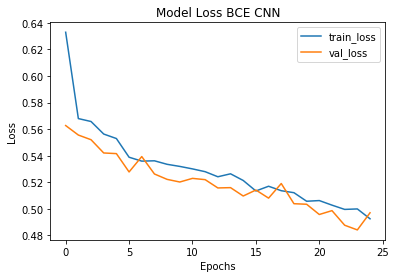

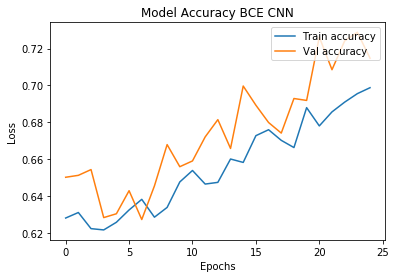

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.755102,0.830794,0.791142,0.706967,0.670838,0.714807
Confirmed,0.613553,0.499255,0.550534,0.706967,0.670838,0.714807


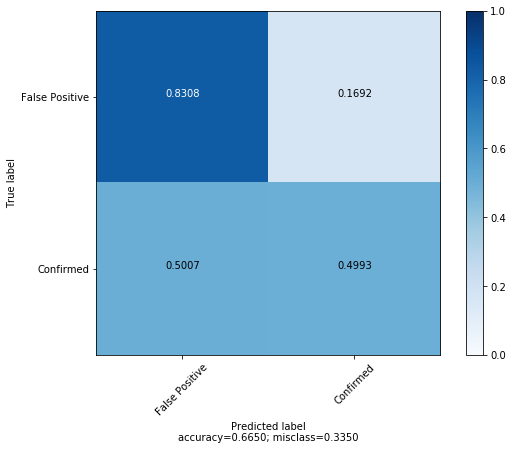

In [24]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 563us/step - loss: 0.4865 - acc: 0.6990 - val_loss: 0.4840 - val_acc: 0.6877
Epoch 2/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4922 - acc: 0.6932 - val_loss: 0.4978 - val_acc: 0.7158
Epoch 3/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4871 - acc: 0.7036 - val_loss: 0.4801 - val_acc: 0.7310
Epoch 4/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4818 - acc: 0.7117 - val_loss: 0.4892 - val_acc: 0.7341
Epoch 5/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4798 - acc: 0.7131 - val_loss: 0.4771 - val_acc: 0.7153
Epoch 6/40
4339/4339 [==============================] - 2s 549us/step - loss: 0.4789 - acc: 0.7101 - val_loss: 0.4773 - val_acc: 0.7252
Epoch 7/40
4339/4339 [==============================] - 2s 547us/step - loss: 0.4799 - acc: 0.7087 - val_loss: 0.4678 - val_acc: 0.7393


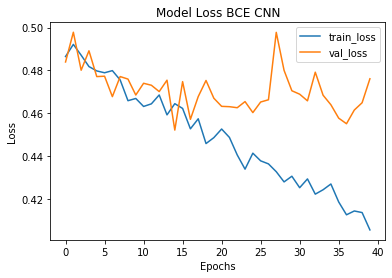

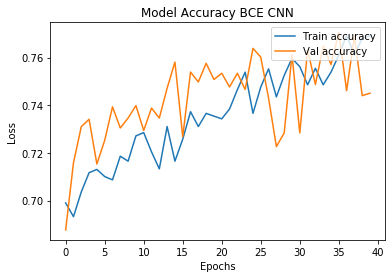

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.814262,0.78749,0.800652,0.746695,0.723537,0.745047
Confirmed,0.627809,0.66617,0.646421,0.746695,0.723537,0.745047


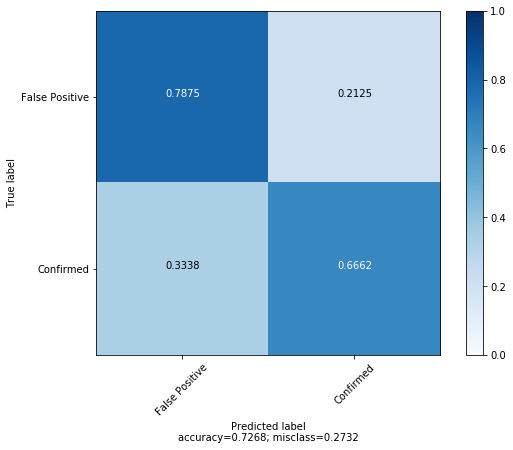

In [25]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

### Modelo 4

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=(1, 1),activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (2, 2), strides=(1, 1), activation="relu", padding="valid"))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 128)     

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 7s 2ms/step - loss: 0.7963 - acc: 0.5935 - val_loss: 1.0067 - val_acc: 0.6512
Epoch 2/25
4339/4339 [==============================] - 4s 833us/step - loss: 0.6455 - acc: 0.6091 - val_loss: 1.0062 - val_acc: 0.5839
Epoch 3/25
4339/4339 [==============================] - 4s 823us/step - loss: 0.6016 - acc: 0.6177 - val_loss: 0.7884 - val_acc: 0.5954
Epoch 4/25
4339/4339 [==============================] - 4s 823us/step - loss: 0.5836 - acc: 0.6289 - val_loss: 0.8926 - val_acc: 0.5798
Epoch 5/25
4339/4339 [==============================] - 4s 826us/step - loss: 0.5751 - acc: 0.6269 - val_loss: 0.7179 - val_acc: 0.5839
Epoch 6/25
4339/4339 [==============================] - 4s 860us/step - loss: 0.5643 - acc: 0.6356 - val_loss: 0.5838 - val_acc: 0.6262
Epoch 7/25
4339/4339 [==============================] - 4s 840us/step - loss: 0.5578 - acc: 0.6366 - val_loss: 0.5416 - val_acc: 0.6554
Ep

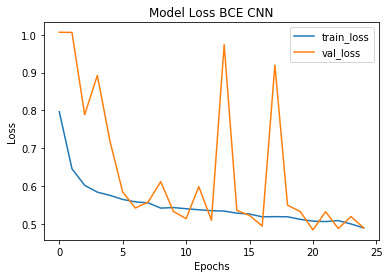

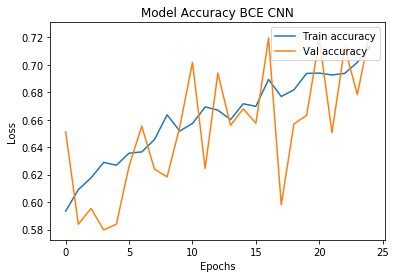

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.731141,0.909383,0.810579,0.698218,0.649991,0.72367
Confirmed,0.692098,0.378539,0.489403,0.698218,0.649991,0.72367


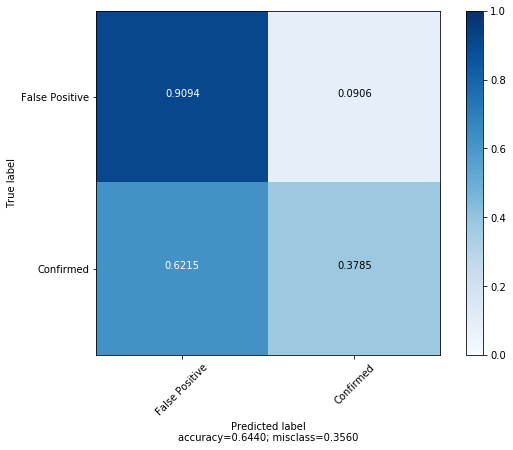

In [27]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 4s 855us/step - loss: 0.4989 - acc: 0.7064 - val_loss: 0.4825 - val_acc: 0.7153
Epoch 2/40
4339/4339 [==============================] - 4s 843us/step - loss: 0.4903 - acc: 0.7121 - val_loss: 0.5201 - val_acc: 0.6851
Epoch 3/40
4339/4339 [==============================] - 4s 848us/step - loss: 0.4936 - acc: 0.7089 - val_loss: 0.5187 - val_acc: 0.6809
Epoch 4/40
4339/4339 [==============================] - 4s 847us/step - loss: 0.4905 - acc: 0.7085 - val_loss: 0.5688 - val_acc: 0.6872
Epoch 5/40
4339/4339 [==============================] - 4s 848us/step - loss: 0.4903 - acc: 0.7085 - val_loss: 0.5765 - val_acc: 0.6710
Epoch 6/40
4339/4339 [==============================] - 4s 834us/step - loss: 0.4780 - acc: 0.7248 - val_loss: 0.4798 - val_acc: 0.7013
Epoch 7/40
4339/4339 [==============================] - 4s 835us/step - loss: 0.4785 - acc: 0.7177 - val_loss: 0.4598 - val_acc: 0.7503


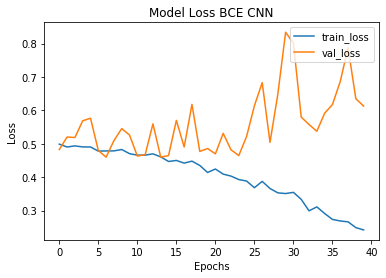

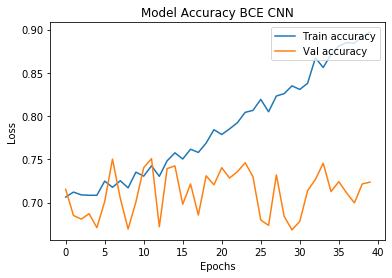

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.827996,0.725742,0.773504,0.7288,0.709613,0.72367
Confirmed,0.585455,0.719821,0.645722,0.7288,0.709613,0.72367


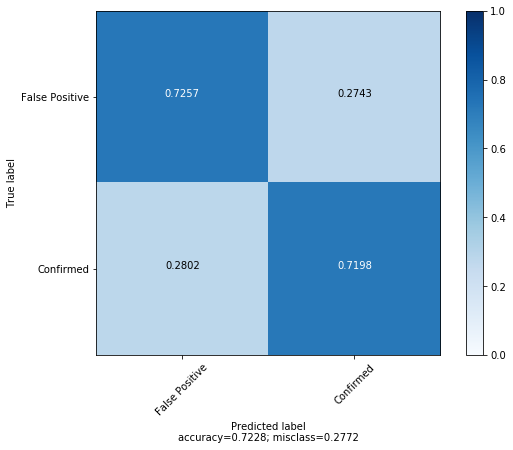

In [28]:
train_model(model, x_train, y_train, x_val, y_val, e=40) 

### Modelo 5, mejor modelo

In [69]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1152)            

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 3s 656us/step - loss: 0.6271 - acc: 0.6190 - val_loss: 0.5618 - val_acc: 0.6293
Epoch 2/25
4339/4339 [==============================] - 1s 200us/step - loss: 0.5756 - acc: 0.6188 - val_loss: 0.5545 - val_acc: 0.6481
Epoch 3/25
4339/4339 [==============================] - 1s 195us/step - loss: 0.5604 - acc: 0.6218 - val_loss: 0.5479 - val_acc: 0.6309
Epoch 4/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5558 - acc: 0.6317 - val_loss: 0.5394 - val_acc: 0.6481
Epoch 5/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5498 - acc: 0.6204 - val_loss: 0.5367 - val_acc: 0.6496
Epoch 6/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5439 - acc: 0.6368 - val_loss: 0.5311 - val_acc: 0.6481
Epoch 7/25
4339/4339 [==============================] - 1s 198us/step - loss: 0.5393 - acc: 0.6354 - val_loss: 0.5269 - val_acc: 0.6580


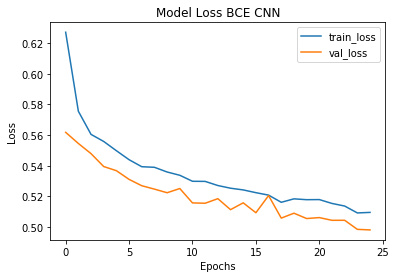

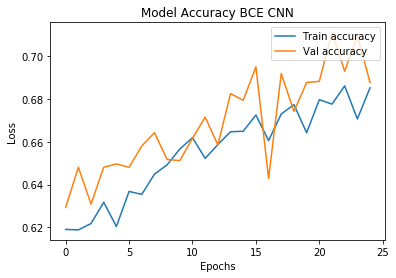

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.802239,0.689655,0.741699,0.693925,0.67342,0.687696
Confirmed,0.542553,0.684054,0.605142,0.693925,0.67342,0.687696


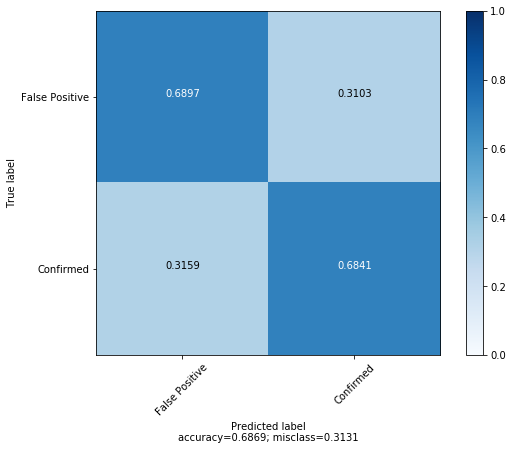

In [70]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 1s 217us/step - loss: 0.5117 - acc: 0.6737 - val_loss: 0.4999 - val_acc: 0.7117
Epoch 2/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5106 - acc: 0.6778 - val_loss: 0.4980 - val_acc: 0.7075
Epoch 3/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5096 - acc: 0.6817 - val_loss: 0.4919 - val_acc: 0.7132
Epoch 4/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5035 - acc: 0.6898 - val_loss: 0.4928 - val_acc: 0.7231
Epoch 5/40
4339/4339 [==============================] - 1s 199us/step - loss: 0.5045 - acc: 0.6905 - val_loss: 0.4879 - val_acc: 0.7174
Epoch 6/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.5014 - acc: 0.6953 - val_loss: 0.4912 - val_acc: 0.7164
Epoch 7/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.4991 - acc: 0.6949 - val_loss: 0.4862 - val_acc: 0.7195


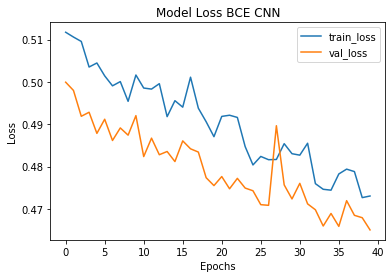

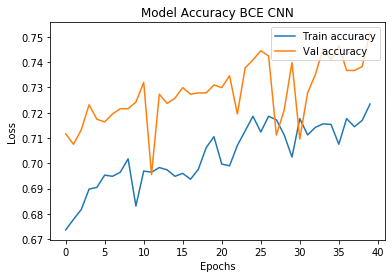

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.767894,0.886127,0.822785,0.739978,0.704436,0.751825
Confirmed,0.703549,0.502235,0.586087,0.739978,0.704436,0.751825


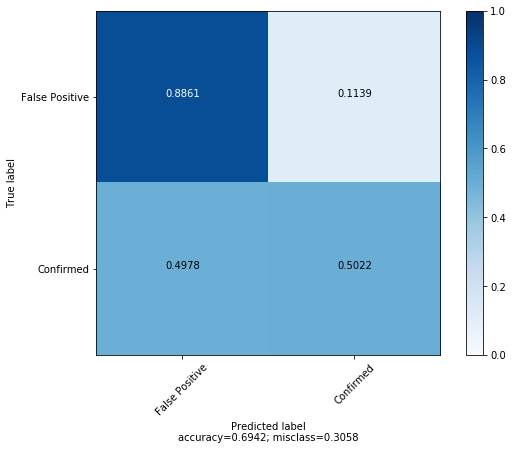

In [71]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 216us/step - loss: 0.4730 - acc: 0.7202 - val_loss: 0.4664 - val_acc: 0.7440
Epoch 2/200
4339/4339 [==============================] - 1s 199us/step - loss: 0.4741 - acc: 0.7186 - val_loss: 0.4725 - val_acc: 0.7482
Epoch 3/200
4339/4339 [==============================] - 1s 199us/step - loss: 0.4707 - acc: 0.7232 - val_loss: 0.4614 - val_acc: 0.7529
Epoch 4/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4673 - acc: 0.7276 - val_loss: 0.4614 - val_acc: 0.7487
Epoch 5/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4674 - acc: 0.7274 - val_loss: 0.4658 - val_acc: 0.7331
Epoch 6/200
4339/4339 [==============================] - 1s 198us/step - loss: 0.4718 - acc: 0.7251 - val_loss: 0.4726 - val_acc: 0.7278
Epoch 7/200
4339/4339 [==============================] - 1s 198us/step - loss: 0.4702 - acc: 0.7214 - val_loss: 0.4647 - val_acc: 

4339/4339 [==============================] - 1s 196us/step - loss: 0.4330 - acc: 0.7647 - val_loss: 0.4521 - val_acc: 0.7643
Epoch 61/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4321 - acc: 0.7594 - val_loss: 0.4493 - val_acc: 0.7690
Epoch 62/200
4339/4339 [==============================] - 1s 195us/step - loss: 0.4339 - acc: 0.7550 - val_loss: 0.4548 - val_acc: 0.7576
Epoch 63/200
4339/4339 [==============================] - 1s 195us/step - loss: 0.4270 - acc: 0.7663 - val_loss: 0.4547 - val_acc: 0.7581
Epoch 64/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4308 - acc: 0.7539 - val_loss: 0.4556 - val_acc: 0.7607
Epoch 65/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.4335 - acc: 0.7534 - val_loss: 0.4561 - val_acc: 0.7544
Epoch 66/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.4319 - acc: 0.7628 - val_loss: 0.4544 - val_acc: 0.7570
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 197us/step - loss: 0.3453 - acc: 0.8276 - val_loss: 0.4570 - val_acc: 0.7742
Epoch 179/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3456 - acc: 0.8242 - val_loss: 0.4630 - val_acc: 0.7602
Epoch 180/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3424 - acc: 0.8301 - val_loss: 0.4651 - val_acc: 0.7696
Epoch 181/200
4339/4339 [==============================] - 1s 197us/step - loss: 0.3294 - acc: 0.8394 - val_loss: 0.4666 - val_acc: 0.7716
Epoch 182/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3449 - acc: 0.8348 - val_loss: 0.4555 - val_acc: 0.7753
Epoch 183/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3478 - acc: 0.8297 - val_loss: 0.4690 - val_acc: 0.7586
Epoch 184/200
4339/4339 [==============================] - 1s 196us/step - loss: 0.3345 - acc: 0.8345 - val_loss: 0.4687 - val_acc: 0.7607
Epoch 185/200
4339/4339 [================

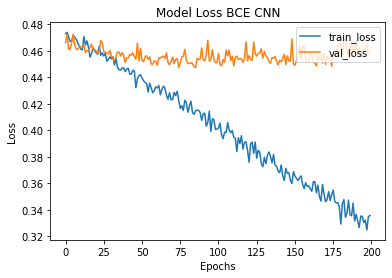

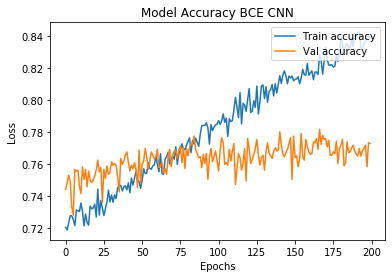

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.829407,0.818765,0.824052,0.773285,0.751496,0.77268
Confirmed,0.671033,0.687034,0.678940,0.773285,0.751496,0.77268


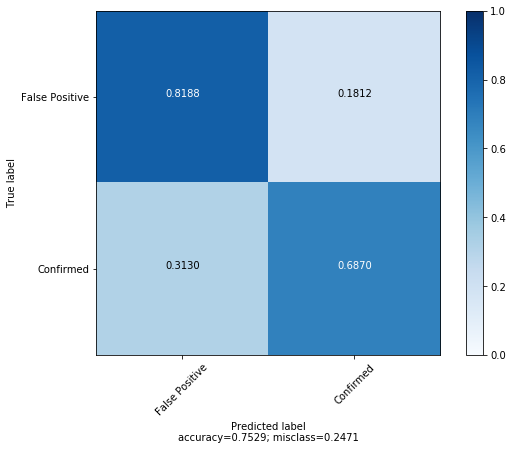

In [72]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

### Modelo 5 con 2 canales

In [94]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1152)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               147584    
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)             

Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 3s 666us/step - loss: 0.6128 - acc: 0.6257 - val_loss: 0.5603 - val_acc: 0.6309
Epoch 2/25
4339/4339 [==============================] - 1s 169us/step - loss: 0.5637 - acc: 0.6241 - val_loss: 0.5501 - val_acc: 0.6142
Epoch 3/25
4339/4339 [==============================] - 1s 150us/step - loss: 0.5564 - acc: 0.6278 - val_loss: 0.5476 - val_acc: 0.6330
Epoch 4/25
4339/4339 [==============================] - 1s 155us/step - loss: 0.5502 - acc: 0.6160 - val_loss: 0.5405 - val_acc: 0.6413
Epoch 5/25
4339/4339 [==============================] - 0s 112us/step - loss: 0.5444 - acc: 0.6276 - val_loss: 0.5375 - val_acc: 0.6423
Epoch 6/25
4339/4339 [==============================] - 1s 151us/step - loss: 0.5423 - acc: 0.6458 - val_loss: 0.5322 - val_acc: 0.6606
Epoch 7/25
4339/4339 [==============================] - 1s 142us/step - loss: 0.5373 - acc: 0.6460 - val_loss: 0.5267 - val_acc: 0.6773


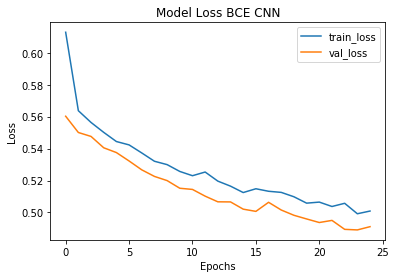

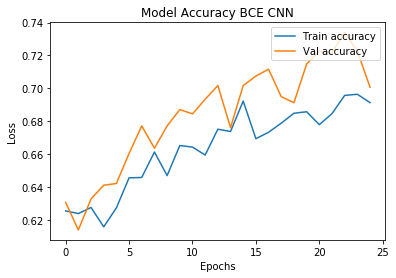

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.816557,0.696071,0.751515,0.706853,0.687684,0.70073
Confirmed,0.556725,0.709389,0.623853,0.706853,0.687684,0.70073


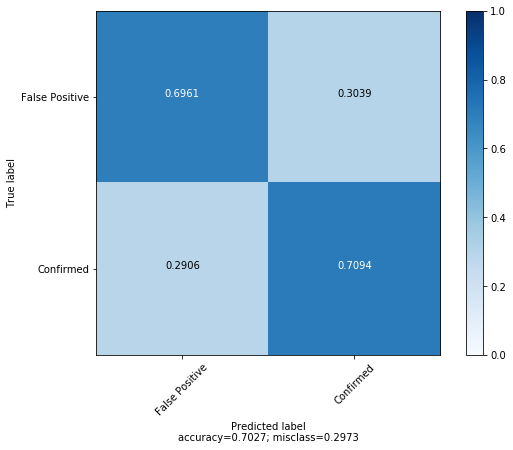

In [95]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 1s 198us/step - loss: 0.4979 - acc: 0.6942 - val_loss: 0.4877 - val_acc: 0.7164
Epoch 2/40
4339/4339 [==============================] - 1s 205us/step - loss: 0.4947 - acc: 0.7020 - val_loss: 0.4855 - val_acc: 0.7195
Epoch 3/40
4339/4339 [==============================] - 1s 182us/step - loss: 0.4954 - acc: 0.7020 - val_loss: 0.4862 - val_acc: 0.7284
Epoch 4/40
4339/4339 [==============================] - 1s 169us/step - loss: 0.4934 - acc: 0.7034 - val_loss: 0.4829 - val_acc: 0.7195
Epoch 5/40
4339/4339 [==============================] - 1s 162us/step - loss: 0.4947 - acc: 0.6919 - val_loss: 0.4833 - val_acc: 0.7367
Epoch 6/40
4339/4339 [==============================] - 1s 169us/step - loss: 0.4865 - acc: 0.7091 - val_loss: 0.4827 - val_acc: 0.7190
Epoch 7/40
4339/4339 [==============================] - 1s 197us/step - loss: 0.4890 - acc: 0.6992 - val_loss: 0.4827 - val_acc: 0.7278


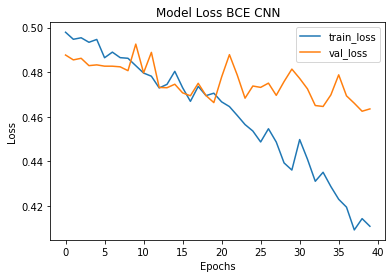

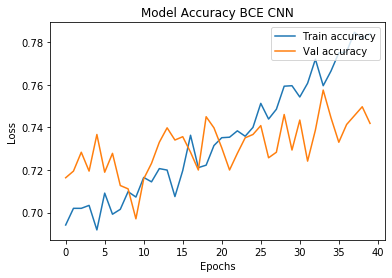

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.781437,0.837209,0.808362,0.737199,0.706655,0.741919
Confirmed,0.651203,0.564829,0.604948,0.737199,0.706655,0.741919


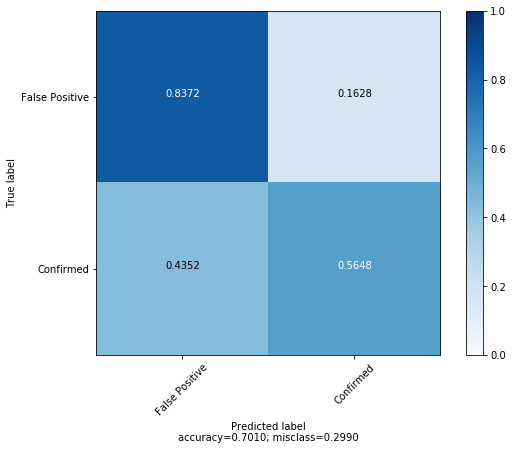

In [96]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 187us/step - loss: 0.4109 - acc: 0.7815 - val_loss: 0.4798 - val_acc: 0.7419
Epoch 2/200
4339/4339 [==============================] - 1s 170us/step - loss: 0.4068 - acc: 0.7919 - val_loss: 0.4716 - val_acc: 0.7492
Epoch 3/200
4339/4339 [==============================] - 1s 137us/step - loss: 0.3965 - acc: 0.7933 - val_loss: 0.4757 - val_acc: 0.7456
Epoch 4/200
4339/4339 [==============================] - 1s 162us/step - loss: 0.3992 - acc: 0.7933 - val_loss: 0.4785 - val_acc: 0.7482
Epoch 5/200
4339/4339 [==============================] - 1s 151us/step - loss: 0.4026 - acc: 0.7877 - val_loss: 0.4699 - val_acc: 0.7393
Epoch 6/200
4339/4339 [==============================] - 1s 129us/step - loss: 0.3962 - acc: 0.8029 - val_loss: 0.4712 - val_acc: 0.7440
Epoch 7/200
4339/4339 [==============================] - 1s 139us/step - loss: 0.3919 - acc: 0.8073 - val_loss: 0.4806 - val_acc: 

4339/4339 [==============================] - 1s 190us/step - loss: 0.1381 - acc: 0.9587 - val_loss: 0.6965 - val_acc: 0.7393
Epoch 61/200
4339/4339 [==============================] - 1s 133us/step - loss: 0.1449 - acc: 0.9479 - val_loss: 0.7280 - val_acc: 0.7487
Epoch 62/200
4339/4339 [==============================] - 1s 138us/step - loss: 0.1413 - acc: 0.9528 - val_loss: 0.7033 - val_acc: 0.7377
Epoch 63/200
4339/4339 [==============================] - 1s 146us/step - loss: 0.1538 - acc: 0.9440 - val_loss: 0.7090 - val_acc: 0.7419
Epoch 64/200
4339/4339 [==============================] - 1s 148us/step - loss: 0.1262 - acc: 0.9606 - val_loss: 0.7553 - val_acc: 0.7492
Epoch 65/200
4339/4339 [==============================] - 1s 184us/step - loss: 0.1206 - acc: 0.9643 - val_loss: 0.7470 - val_acc: 0.7424
Epoch 66/200
4339/4339 [==============================] - 1s 181us/step - loss: 0.1186 - acc: 0.9664 - val_loss: 0.7374 - val_acc: 0.7388
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 0s 112us/step - loss: 0.0073 - acc: 0.9991 - val_loss: 1.5444 - val_acc: 0.7450
Epoch 179/200
4339/4339 [==============================] - 1s 135us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 1.5098 - val_acc: 0.7445
Epoch 180/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 1.5950 - val_acc: 0.7487
Epoch 181/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 1.6926 - val_acc: 0.7508
Epoch 182/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0053 - acc: 0.9998 - val_loss: 1.6381 - val_acc: 0.7456
Epoch 183/200
4339/4339 [==============================] - 1s 120us/step - loss: 0.0058 - acc: 0.9998 - val_loss: 1.6544 - val_acc: 0.7471
Epoch 184/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0106 - acc: 0.9972 - val_loss: 1.6033 - val_acc: 0.7477
Epoch 185/200
4339/4339 [================

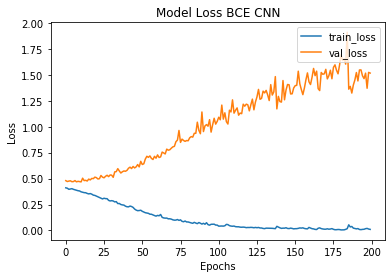

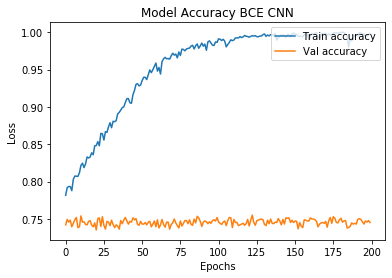

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.806634,0.799519,0.803061,0.745519,0.720821,0.745047
Confirmed,0.633431,0.643815,0.638581,0.745519,0.720821,0.745047


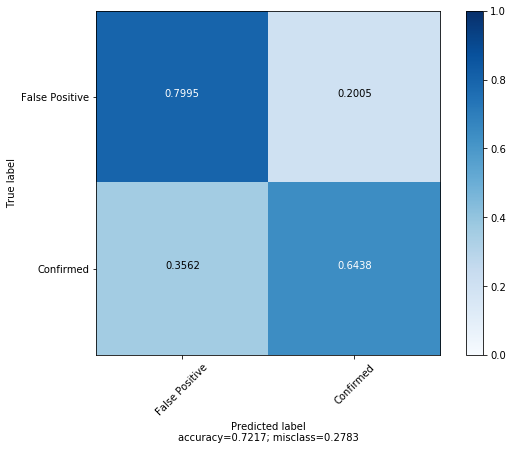

In [97]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

In [102]:
!ls /work/work_teamEXOPLANET/MTF_gabo/npys/

time_channel_30.npy


## Modelo 6

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)         295168    


Train on 4339 samples, validate on 1918 samples
Epoch 1/25
4339/4339 [==============================] - 3s 803us/step - loss: 0.6192 - acc: 0.6250 - val_loss: 0.5773 - val_acc: 0.6502
Epoch 2/25
4339/4339 [==============================] - 2s 407us/step - loss: 0.5660 - acc: 0.6246 - val_loss: 0.5500 - val_acc: 0.6502
Epoch 3/25
4339/4339 [==============================] - 2s 366us/step - loss: 0.5542 - acc: 0.6283 - val_loss: 0.5407 - val_acc: 0.6502
Epoch 4/25
4339/4339 [==============================] - 2s 362us/step - loss: 0.5449 - acc: 0.6234 - val_loss: 0.5323 - val_acc: 0.6314
Epoch 5/25
4339/4339 [==============================] - 2s 441us/step - loss: 0.5338 - acc: 0.6158 - val_loss: 0.5279 - val_acc: 0.6449
Epoch 6/25
4339/4339 [==============================] - 1s 339us/step - loss: 0.5311 - acc: 0.6361 - val_loss: 0.5312 - val_acc: 0.6460
Epoch 7/25
4339/4339 [==============================] - 2s 522us/step - loss: 0.5327 - acc: 0.6423 - val_loss: 0.5221 - val_acc: 0.6371


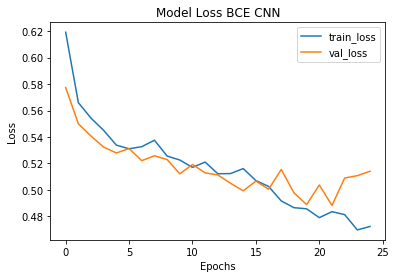

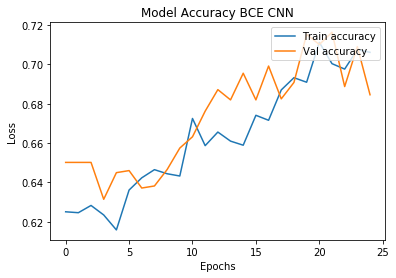

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.895320,0.582999,0.706168,0.689855,0.682853,0.684567
Confirmed,0.529837,0.873323,0.659539,0.689855,0.682853,0.684567


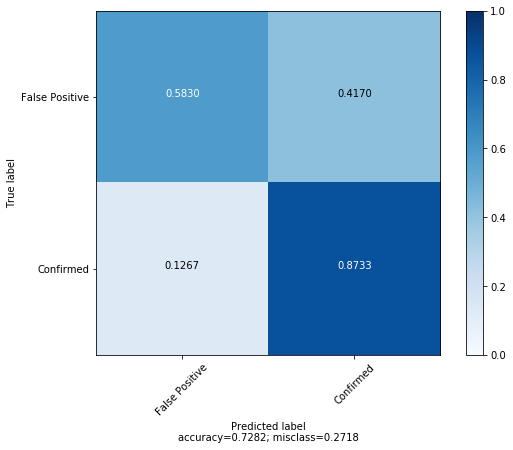

In [16]:
train_model(model, x_train, y_train, x_val, y_val, e=25)

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 448us/step - loss: 0.4681 - acc: 0.7138 - val_loss: 0.4796 - val_acc: 0.7383
Epoch 2/40
4339/4339 [==============================] - 1s 341us/step - loss: 0.4561 - acc: 0.7338 - val_loss: 0.4862 - val_acc: 0.7294
Epoch 3/40
4339/4339 [==============================] - 2s 446us/step - loss: 0.4510 - acc: 0.7301 - val_loss: 0.4921 - val_acc: 0.7320
Epoch 4/40
4339/4339 [==============================] - 2s 385us/step - loss: 0.4513 - acc: 0.7320 - val_loss: 0.5261 - val_acc: 0.7148
Epoch 5/40
4339/4339 [==============================] - 2s 396us/step - loss: 0.4580 - acc: 0.7156 - val_loss: 0.4983 - val_acc: 0.7315
Epoch 6/40
4339/4339 [==============================] - 2s 482us/step - loss: 0.4603 - acc: 0.7331 - val_loss: 0.4845 - val_acc: 0.7518
Epoch 7/40
4339/4339 [==============================] - 2s 348us/step - loss: 0.4356 - acc: 0.7488 - val_loss: 0.5001 - val_acc: 0.7226


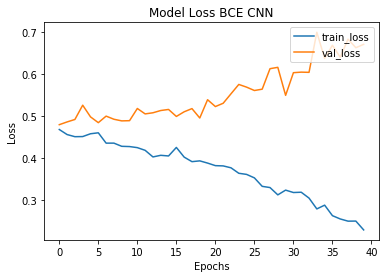

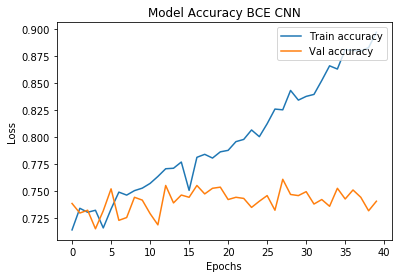

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.797932,0.804330,0.801118,0.739898,0.713622,0.740355
Confirmed,0.630862,0.621461,0.626126,0.739898,0.713622,0.740355


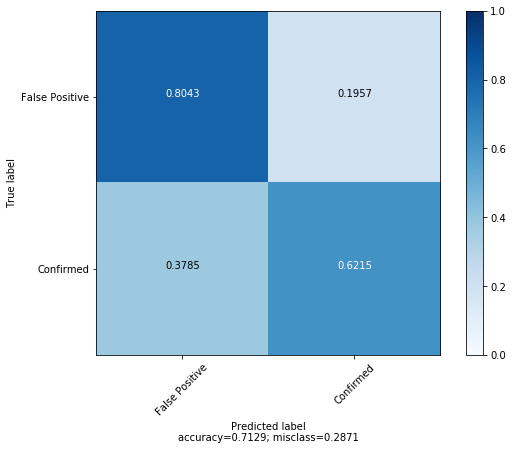

In [17]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 2s 398us/step - loss: 0.2557 - acc: 0.8783 - val_loss: 0.6948 - val_acc: 0.7461
Epoch 2/200
4339/4339 [==============================] - 2s 546us/step - loss: 0.2242 - acc: 0.8995 - val_loss: 0.6759 - val_acc: 0.7440
Epoch 3/200
4339/4339 [==============================] - 2s 465us/step - loss: 0.1968 - acc: 0.9117 - val_loss: 0.7306 - val_acc: 0.7388
Epoch 4/200
4339/4339 [==============================] - 2s 441us/step - loss: 0.1888 - acc: 0.9182 - val_loss: 0.7987 - val_acc: 0.7393
Epoch 5/200
4339/4339 [==============================] - 2s 467us/step - loss: 0.1812 - acc: 0.9226 - val_loss: 0.8361 - val_acc: 0.7398
Epoch 6/200
4339/4339 [==============================] - 2s 456us/step - loss: 0.1629 - acc: 0.9318 - val_loss: 0.8925 - val_acc: 0.7424
Epoch 7/200
4339/4339 [==============================] - 2s 406us/step - loss: 0.1691 - acc: 0.9263 - val_loss: 0.8941 - val_acc: 

4339/4339 [==============================] - 2s 373us/step - loss: 0.0139 - acc: 0.9970 - val_loss: 1.6720 - val_acc: 0.7503
Epoch 61/200
4339/4339 [==============================] - 1s 316us/step - loss: 0.0281 - acc: 0.9899 - val_loss: 1.7655 - val_acc: 0.7346
Epoch 62/200
4339/4339 [==============================] - 2s 449us/step - loss: 0.0224 - acc: 0.9908 - val_loss: 1.6708 - val_acc: 0.7523
Epoch 63/200
4339/4339 [==============================] - 2s 426us/step - loss: 0.0109 - acc: 0.9963 - val_loss: 1.7057 - val_acc: 0.7518
Epoch 64/200
4339/4339 [==============================] - 1s 338us/step - loss: 0.0083 - acc: 0.9977 - val_loss: 1.7934 - val_acc: 0.7388
Epoch 65/200
4339/4339 [==============================] - 2s 447us/step - loss: 0.0102 - acc: 0.9963 - val_loss: 1.6997 - val_acc: 0.7497
Epoch 66/200
4339/4339 [==============================] - 1s 339us/step - loss: 0.0337 - acc: 0.9871 - val_loss: 2.0339 - val_acc: 0.7132
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 2s 434us/step - loss: 5.0536e-05 - acc: 1.0000 - val_loss: 2.2448 - val_acc: 0.7482
Epoch 119/200
4339/4339 [==============================] - 2s 392us/step - loss: 4.8162e-05 - acc: 1.0000 - val_loss: 2.2531 - val_acc: 0.7456
Epoch 120/200
4339/4339 [==============================] - 2s 468us/step - loss: 4.9268e-05 - acc: 1.0000 - val_loss: 2.2537 - val_acc: 0.7471
Epoch 121/200
4339/4339 [==============================] - 2s 356us/step - loss: 4.2535e-05 - acc: 1.0000 - val_loss: 2.2604 - val_acc: 0.7456
Epoch 122/200
4339/4339 [==============================] - 2s 348us/step - loss: 4.4257e-05 - acc: 1.0000 - val_loss: 2.2636 - val_acc: 0.7456
Epoch 123/200
4339/4339 [==============================] - 2s 408us/step - loss: 4.1087e-05 - acc: 1.0000 - val_loss: 2.2686 - val_acc: 0.7471
Epoch 124/200
4339/4339 [==============================] - 2s 436us/step - loss: 4.1113e-05 - acc: 1.0000 - val_loss: 2.2719 - val_acc: 0.7466
Epoch 125/200

4339/4339 [==============================] - 2s 423us/step - loss: 7.5958e-06 - acc: 1.0000 - val_loss: 2.4639 - val_acc: 0.7477
Epoch 176/200
4339/4339 [==============================] - 2s 469us/step - loss: 8.6508e-06 - acc: 1.0000 - val_loss: 2.4684 - val_acc: 0.7477
Epoch 177/200
4339/4339 [==============================] - 2s 382us/step - loss: 7.5867e-06 - acc: 1.0000 - val_loss: 2.4739 - val_acc: 0.7477
Epoch 178/200
4339/4339 [==============================] - 2s 388us/step - loss: 6.9658e-06 - acc: 1.0000 - val_loss: 2.4719 - val_acc: 0.7482
Epoch 179/200
4339/4339 [==============================] - 2s 346us/step - loss: 7.3924e-06 - acc: 1.0000 - val_loss: 2.4789 - val_acc: 0.7482
Epoch 180/200
4339/4339 [==============================] - 2s 442us/step - loss: 7.7654e-06 - acc: 1.0000 - val_loss: 2.4844 - val_acc: 0.7482
Epoch 181/200
4339/4339 [==============================] - 2s 392us/step - loss: 7.3393e-06 - acc: 1.0000 - val_loss: 2.4837 - val_acc: 0.7487
Epoch 182/200

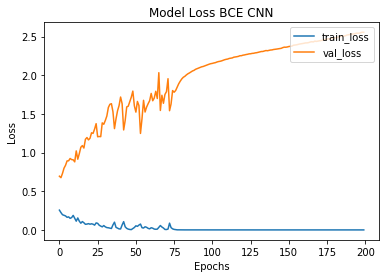

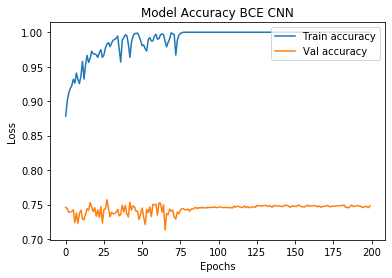

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.811075,0.798717,0.804848,0.748966,0.724981,0.748175
Confirmed,0.636232,0.654247,0.645114,0.748966,0.724981,0.748175


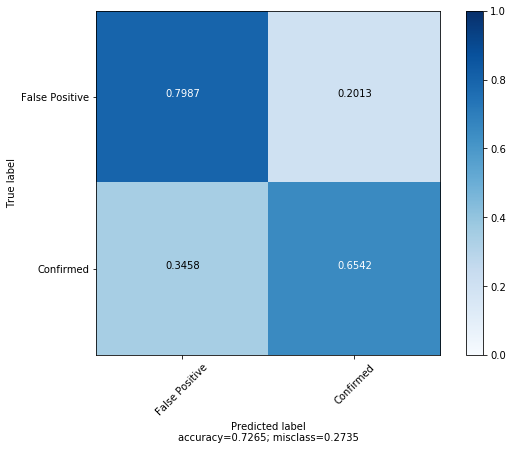

In [18]:
train_model(model, x_train, y_train, x_val, y_val, e=200)

### Modelo 7, Supuesta best estructura

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 347us/step - loss: 0.6264 - acc: 0.6319 - val_loss: 0.5640 - val_acc: 0.6502
Epoch 2/40
4339/4339 [==============================] - 1s 131us/step - loss: 0.5703 - acc: 0.6112 - val_loss: 0.5500 - val_acc: 0.6502
Epoch 3/40
4339/4339 [==============================] - 1s 328us/step - loss: 0.5531 - acc: 0.6324 - val_loss: 0.5403 - val_acc: 0.6319
Epoch 4/40
4339/4339 [==============================] - 1s 326us/step - loss: 0.5480 - acc: 0.6248 - val_loss: 0.5367 - val_acc: 0.6376
Epoch 5/40
4339/4339 [==============================] - 1s 138us/step - loss: 0.5406 - acc: 0.6250 - val_loss: 0.5253 - val_acc: 0.6658
Epoch 6/40
4339/4339 [==============================] - 1s 156us/step - loss: 0.5348 - acc: 0.6340 - val_loss: 0.5307 - val_acc: 0.6470
Epoch 7/40
4339/4339 [==============================] - 1s 129us/step - loss: 0.5344 - acc: 0.6455 - val_loss: 0.5213 - val_acc: 0.6538


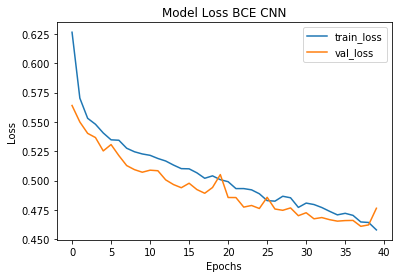

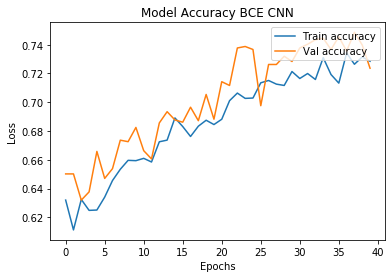

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.712256,0.964715,0.819482,0.676616,0.615297,0.72367
Confirmed,0.807860,0.275708,0.411111,0.676616,0.615297,0.72367


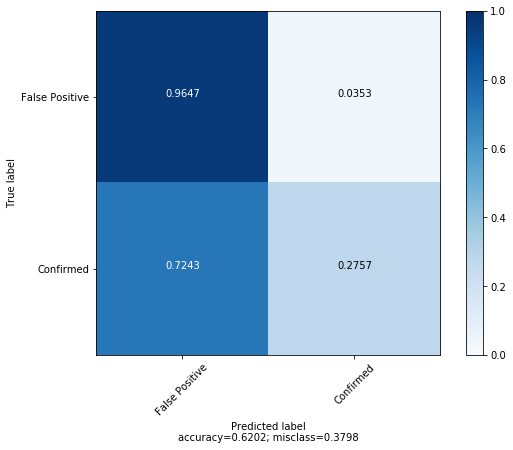

In [20]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

Train on 4339 samples, validate on 1918 samples
Epoch 1/60
4339/4339 [==============================] - 1s 129us/step - loss: 0.4656 - acc: 0.7343 - val_loss: 0.4568 - val_acc: 0.7419
Epoch 2/60
4339/4339 [==============================] - 0s 110us/step - loss: 0.4539 - acc: 0.7322 - val_loss: 0.4566 - val_acc: 0.7550
Epoch 3/60
4339/4339 [==============================] - 1s 121us/step - loss: 0.4567 - acc: 0.7370 - val_loss: 0.4618 - val_acc: 0.7440
Epoch 4/60
4339/4339 [==============================] - 0s 112us/step - loss: 0.4512 - acc: 0.7389 - val_loss: 0.4717 - val_acc: 0.7372
Epoch 5/60
4339/4339 [==============================] - 0s 108us/step - loss: 0.4540 - acc: 0.7333 - val_loss: 0.4548 - val_acc: 0.7534
Epoch 6/60
4339/4339 [==============================] - 0s 111us/step - loss: 0.4478 - acc: 0.7460 - val_loss: 0.4575 - val_acc: 0.7440
Epoch 7/60
4339/4339 [==============================] - 0s 109us/step - loss: 0.4493 - acc: 0.7493 - val_loss: 0.4572 - val_acc: 0.7430


4339/4339 [==============================] - 1s 327us/step - loss: 0.2953 - acc: 0.8638 - val_loss: 0.5119 - val_acc: 0.7377


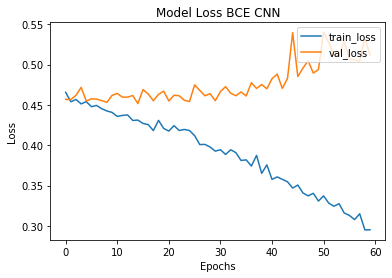

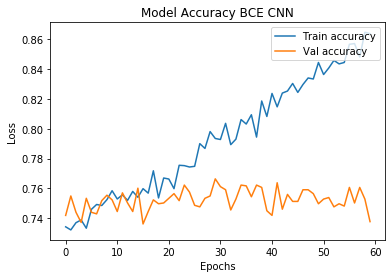

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.840659,0.736167,0.784951,0.742635,0.724473,0.737748
Confirmed,0.601695,0.740686,0.663995,0.742635,0.724473,0.737748


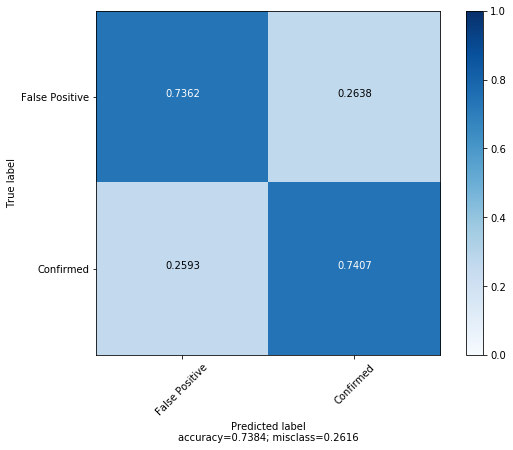

In [21]:
train_model(model, x_train, y_train, x_val, y_val, e=60) #old test

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 2s 350us/step - loss: 0.2962 - acc: 0.8587 - val_loss: 0.5723 - val_acc: 0.7497
Epoch 2/200
4339/4339 [==============================] - 1s 327us/step - loss: 0.2862 - acc: 0.8613 - val_loss: 0.5394 - val_acc: 0.7424
Epoch 3/200
4339/4339 [==============================] - 0s 114us/step - loss: 0.2753 - acc: 0.8818 - val_loss: 0.5456 - val_acc: 0.7628
Epoch 4/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.2752 - acc: 0.8744 - val_loss: 0.5318 - val_acc: 0.7550
Epoch 5/200
4339/4339 [==============================] - 1s 124us/step - loss: 0.2638 - acc: 0.8857 - val_loss: 0.5291 - val_acc: 0.7503
Epoch 6/200
4339/4339 [==============================] - 1s 325us/step - loss: 0.2692 - acc: 0.8820 - val_loss: 0.5364 - val_acc: 0.7466
Epoch 7/200
4339/4339 [==============================] - 0s 109us/step - loss: 0.2572 - acc: 0.8891 - val_loss: 0.5483 - val_acc: 

4339/4339 [==============================] - 0s 113us/step - loss: 0.0806 - acc: 0.9737 - val_loss: 0.8462 - val_acc: 0.7654
Epoch 61/200
4339/4339 [==============================] - 0s 102us/step - loss: 0.0755 - acc: 0.9783 - val_loss: 0.8598 - val_acc: 0.7586
Epoch 62/200
4339/4339 [==============================] - 0s 106us/step - loss: 0.0909 - acc: 0.9673 - val_loss: 0.8161 - val_acc: 0.7534
Epoch 63/200
4339/4339 [==============================] - 1s 119us/step - loss: 0.0906 - acc: 0.9657 - val_loss: 0.8848 - val_acc: 0.7518
Epoch 64/200
4339/4339 [==============================] - 1s 333us/step - loss: 0.0800 - acc: 0.9705 - val_loss: 0.8793 - val_acc: 0.7503
Epoch 65/200
4339/4339 [==============================] - 0s 113us/step - loss: 0.0795 - acc: 0.9746 - val_loss: 0.8964 - val_acc: 0.7643
Epoch 66/200
4339/4339 [==============================] - 1s 317us/step - loss: 0.0812 - acc: 0.9744 - val_loss: 0.8720 - val_acc: 0.7643
Epoch 67/200
4339/4339 [=======================

4339/4339 [==============================] - 1s 327us/step - loss: 0.0198 - acc: 0.9952 - val_loss: 1.2503 - val_acc: 0.7607
Epoch 120/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0169 - acc: 0.9968 - val_loss: 1.2535 - val_acc: 0.7529
Epoch 121/200
4339/4339 [==============================] - 0s 110us/step - loss: 0.0435 - acc: 0.9850 - val_loss: 1.1973 - val_acc: 0.7560
Epoch 122/200
4339/4339 [==============================] - 0s 114us/step - loss: 0.0302 - acc: 0.9917 - val_loss: 1.2639 - val_acc: 0.7555
Epoch 123/200
4339/4339 [==============================] - 0s 105us/step - loss: 0.0252 - acc: 0.9935 - val_loss: 1.2291 - val_acc: 0.7628
Epoch 124/200
4339/4339 [==============================] - 1s 117us/step - loss: 0.0167 - acc: 0.9965 - val_loss: 1.3061 - val_acc: 0.7560
Epoch 125/200
4339/4339 [==============================] - 1s 123us/step - loss: 0.0198 - acc: 0.9942 - val_loss: 1.2547 - val_acc: 0.7638
Epoch 126/200
4339/4339 [================

4339/4339 [==============================] - 1s 123us/step - loss: 0.0324 - acc: 0.9869 - val_loss: 1.4166 - val_acc: 0.7555
Epoch 179/200
4339/4339 [==============================] - 1s 124us/step - loss: 0.0309 - acc: 0.9899 - val_loss: 1.4195 - val_acc: 0.7596
Epoch 180/200
4339/4339 [==============================] - 1s 119us/step - loss: 0.0185 - acc: 0.9952 - val_loss: 1.5387 - val_acc: 0.7628
Epoch 181/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.0086 - acc: 0.9977 - val_loss: 1.5085 - val_acc: 0.7612
Epoch 182/200
4339/4339 [==============================] - 1s 117us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 1.5784 - val_acc: 0.7654
Epoch 183/200
4339/4339 [==============================] - 1s 132us/step - loss: 0.0046 - acc: 0.9998 - val_loss: 1.5784 - val_acc: 0.7544
Epoch 184/200
4339/4339 [==============================] - 1s 125us/step - loss: 0.0083 - acc: 0.9984 - val_loss: 1.5943 - val_acc: 0.7638
Epoch 185/200
4339/4339 [================

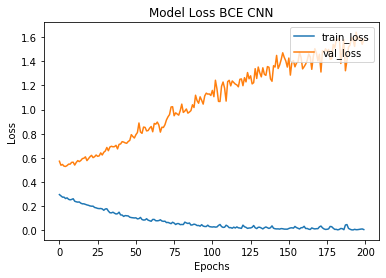

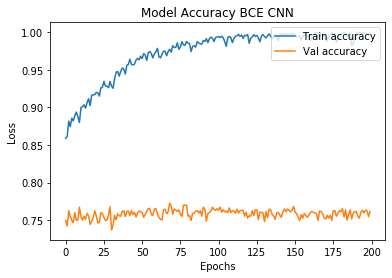

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.812500,0.823577,0.818001,0.761009,0.736548,0.761731
Confirmed,0.663609,0.646796,0.655094,0.761009,0.736548,0.761731


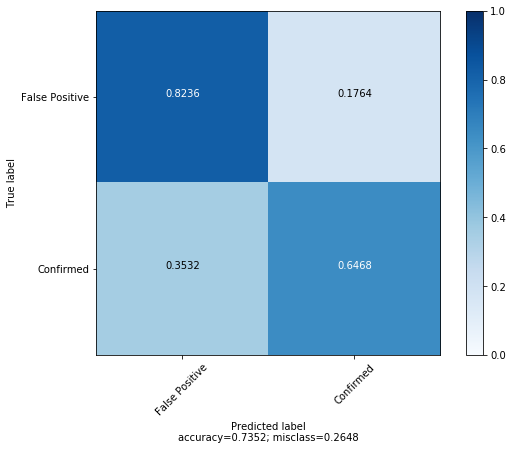

In [22]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #old test

## Pruebas CNN utilizando loss = Focal_Loss

In [23]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.79497985 1.34751553]


In [24]:
import tensorflow as tf
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [25]:
## experimetanciones varias -- modelo 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

#model.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
#model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])
#model.compile(loss=binary_focal_loss(alpha=.25, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 489us/step - loss: 9.8874 - acc: 0.6004 - val_loss: 8.9973 - val_acc: 0.5996
Epoch 2/40
4339/4339 [==============================] - 1s 207us/step - loss: 9.0593 - acc: 0.6059 - val_loss: 8.8211 - val_acc: 0.6194
Epoch 3/40
4339/4339 [==============================] - 1s 208us/step - loss: 8.9962 - acc: 0.6100 - val_loss: 8.7304 - val_acc: 0.6116
Epoch 4/40
4339/4339 [==============================] - 1s 229us/step - loss: 8.8680 - acc: 0.6147 - val_loss: 8.7866 - val_acc: 0.6262
Epoch 5/40
4339/4339 [==============================] - 1s 216us/step - loss: 8.7877 - acc: 0.6200 - val_loss: 8.8097 - val_acc: 0.5782
Epoch 6/40
4339/4339 [==============================] - 1s 211us/step - loss: 8.6613 - acc: 0.6190 - val_loss: 8.5803 - val_acc: 0.5991
Epoch 7/40
4339/4339 [==============================] - 1s 211us/step - loss: 8.5929 - acc: 0.6218 - val_loss: 8.6942 - val_acc: 0.6335


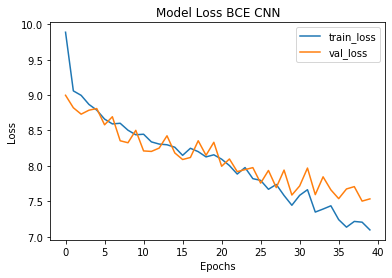

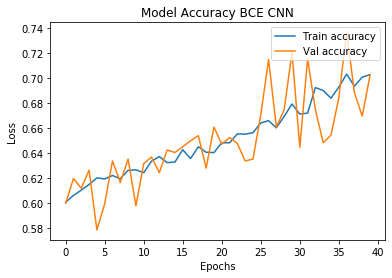

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.908213,0.603047,0.724819,0.707654,0.700286,0.702294
Confirmed,0.545872,0.886736,0.675752,0.707654,0.700286,0.702294


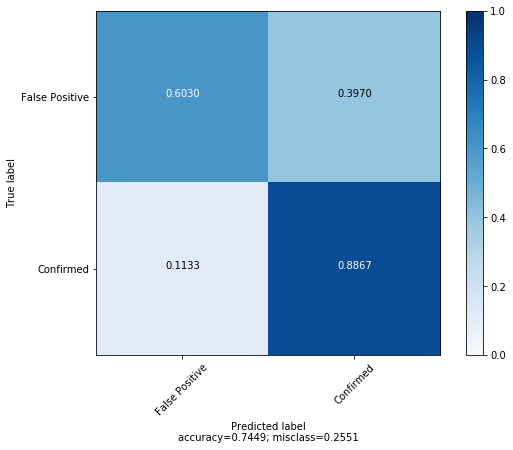

In [26]:
train_model(model, x_train, y_train, x_val, y_val, e=40) #old test

Train on 4339 samples, validate on 1918 samples
Epoch 1/60
4339/4339 [==============================] - 1s 231us/step - loss: 7.0532 - acc: 0.7177 - val_loss: 7.5688 - val_acc: 0.6794
Epoch 2/60
4339/4339 [==============================] - 1s 216us/step - loss: 6.9335 - acc: 0.7142 - val_loss: 8.2992 - val_acc: 0.7086
Epoch 3/60
4339/4339 [==============================] - 1s 214us/step - loss: 6.9894 - acc: 0.7135 - val_loss: 7.7804 - val_acc: 0.7216
Epoch 4/60
4339/4339 [==============================] - 1s 214us/step - loss: 6.9858 - acc: 0.7246 - val_loss: 8.6632 - val_acc: 0.7372
Epoch 5/60
4339/4339 [==============================] - 1s 225us/step - loss: 7.3357 - acc: 0.7078 - val_loss: 8.0255 - val_acc: 0.6752
Epoch 6/60
4339/4339 [==============================] - 1s 227us/step - loss: 6.9394 - acc: 0.7055 - val_loss: 7.9283 - val_acc: 0.7372
Epoch 7/60
4339/4339 [==============================] - 1s 211us/step - loss: 6.8306 - acc: 0.7246 - val_loss: 7.4949 - val_acc: 0.6940


4339/4339 [==============================] - 1s 234us/step - loss: 1.4489 - acc: 0.9645 - val_loss: 18.2524 - val_acc: 0.7523


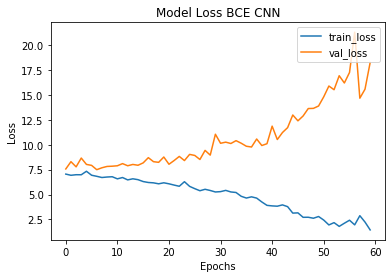

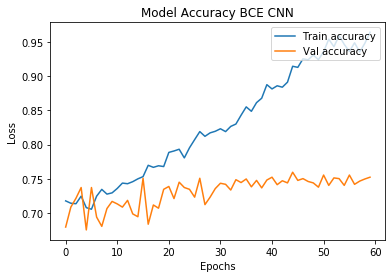

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.813312,0.803528,0.808390,0.752966,0.729177,0.752346
Confirmed,0.642857,0.657228,0.649963,0.752966,0.729177,0.752346


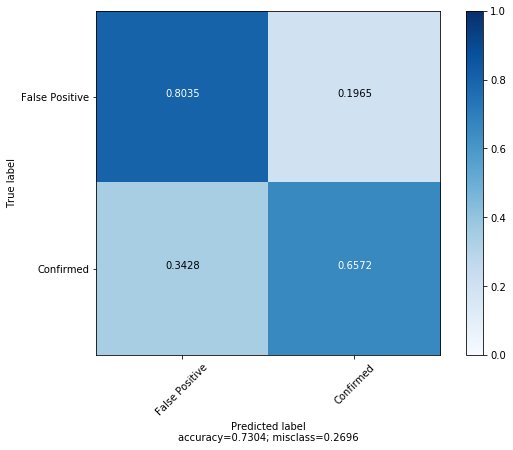

In [27]:
train_model(model, x_train, y_train, x_val, y_val, e=60) #old test

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 242us/step - loss: 1.2193 - acc: 0.9749 - val_loss: 18.3857 - val_acc: 0.7523
Epoch 2/200
4339/4339 [==============================] - 1s 231us/step - loss: 1.0802 - acc: 0.9795 - val_loss: 17.1442 - val_acc: 0.7534
Epoch 3/200
4339/4339 [==============================] - 1s 244us/step - loss: 1.3481 - acc: 0.9689 - val_loss: 17.9339 - val_acc: 0.7461
Epoch 4/200
4339/4339 [==============================] - 1s 239us/step - loss: 1.3032 - acc: 0.9703 - val_loss: 19.2060 - val_acc: 0.7534
Epoch 5/200
4339/4339 [==============================] - 1s 241us/step - loss: 0.9591 - acc: 0.9802 - val_loss: 19.5223 - val_acc: 0.7544
Epoch 6/200
4339/4339 [==============================] - 1s 244us/step - loss: 1.0313 - acc: 0.9788 - val_loss: 22.4351 - val_acc: 0.7529
Epoch 7/200
4339/4339 [==============================] - 1s 251us/step - loss: 2.3388 - acc: 0.9364 - val_loss: 15.9007 - va

4339/4339 [==============================] - 1s 234us/step - loss: 0.0272 - acc: 1.0000 - val_loss: 38.4277 - val_acc: 0.7649
Epoch 60/200
4339/4339 [==============================] - 1s 234us/step - loss: 0.3575 - acc: 0.9945 - val_loss: 56.2317 - val_acc: 0.7430
Epoch 61/200
4339/4339 [==============================] - 1s 233us/step - loss: 9.2533 - acc: 0.7237 - val_loss: 9.6749 - val_acc: 0.6528
Epoch 62/200
4339/4339 [==============================] - 1s 234us/step - loss: 6.8856 - acc: 0.7310 - val_loss: 8.6873 - val_acc: 0.6955
Epoch 63/200
4339/4339 [==============================] - 1s 234us/step - loss: 5.3198 - acc: 0.8228 - val_loss: 11.0704 - val_acc: 0.7252
Epoch 64/200
4339/4339 [==============================] - 1s 235us/step - loss: 3.4903 - acc: 0.9101 - val_loss: 11.6661 - val_acc: 0.7617
Epoch 65/200
4339/4339 [==============================] - 1s 248us/step - loss: 1.9750 - acc: 0.9523 - val_loss: 18.5170 - val_acc: 0.7628
Epoch 66/200
4339/4339 [==================

Epoch 118/200
4339/4339 [==============================] - 1s 244us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 41.3331 - val_acc: 0.7581
Epoch 119/200
4339/4339 [==============================] - 1s 231us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 41.4298 - val_acc: 0.7591
Epoch 120/200
4339/4339 [==============================] - 1s 241us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 41.5134 - val_acc: 0.7623
Epoch 121/200
4339/4339 [==============================] - 1s 234us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 41.6392 - val_acc: 0.7628
Epoch 122/200
4339/4339 [==============================] - 1s 232us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 41.6934 - val_acc: 0.7607
Epoch 123/200
4339/4339 [==============================] - 1s 229us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 41.8417 - val_acc: 0.7560
Epoch 124/200
4339/4339 [==============================] - 1s 233us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 42.6938 - val_acc: 0.7591
Epoch 125/200
4339/4

4339/4339 [==============================] - 1s 227us/step - loss: 14.7538 - acc: 0.6363 - val_loss: 8.6575 - val_acc: 0.6653
Epoch 177/200
4339/4339 [==============================] - 1s 226us/step - loss: 8.7639 - acc: 0.6043 - val_loss: 8.5013 - val_acc: 0.6267
Epoch 178/200
4339/4339 [==============================] - 1s 232us/step - loss: 8.3527 - acc: 0.6248 - val_loss: 8.2506 - val_acc: 0.6157
Epoch 179/200
4339/4339 [==============================] - 1s 227us/step - loss: 8.3052 - acc: 0.6255 - val_loss: 8.1817 - val_acc: 0.6387
Epoch 180/200
4339/4339 [==============================] - 1s 228us/step - loss: 8.1843 - acc: 0.6363 - val_loss: 8.6790 - val_acc: 0.6382
Epoch 181/200
4339/4339 [==============================] - 1s 224us/step - loss: 8.1692 - acc: 0.6347 - val_loss: 8.3594 - val_acc: 0.6319
Epoch 182/200
4339/4339 [==============================] - 1s 223us/step - loss: 8.1171 - acc: 0.6423 - val_loss: 8.5378 - val_acc: 0.6528
Epoch 183/200
4339/4339 [===============

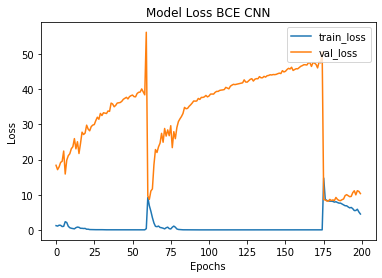

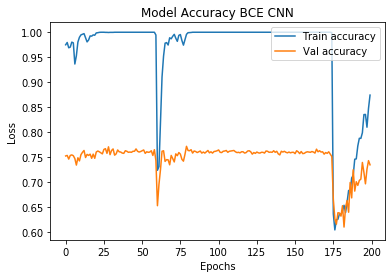

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.844860,0.724940,0.780319,0.739945,0.722615,0.734619
Confirmed,0.595519,0.752608,0.664911,0.739945,0.722615,0.734619


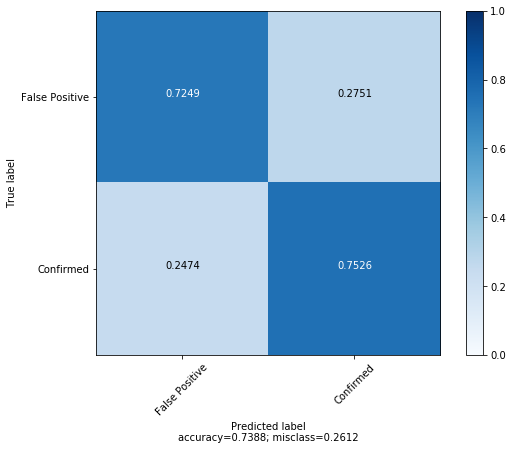

In [28]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #old test

In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 360us/step - loss: 9.5000 - acc: 0.6064 - val_loss: 8.8365 - val_acc: 0.6277
Epoch 2/40
4339/4339 [==============================] - 0s 109us/step - loss: 8.8375 - acc: 0.6193 - val_loss: 8.5669 - val_acc: 0.6298
Epoch 3/40
4339/4339 [==============================] - 0s 102us/step - loss: 8.6912 - acc: 0.6200 - val_loss: 8.4357 - val_acc: 0.6330
Epoch 4/40
4339/4339 [==============================] - 0s 111us/step - loss: 8.5045 - acc: 0.6322 - val_loss: 8.4561 - val_acc: 0.6111
Epoch 5/40
4339/4339 [==============================] - 0s 112us/step - loss: 8.4142 - acc: 0.6299 - val_loss: 8.2256 - val_acc: 0.6397
Epoch 6/40
4339/4339 [==============================] - 0s 109us/step - loss: 8.3349 - acc: 0.6331 - val_loss: 8.2269 - val_acc: 0.6408
Epoch 7/40
4339/4339 [==============================] - 0s 114us/step - loss: 8.2579 - acc: 0.6391 - val_loss: 8.1252 - val_acc: 0.6408


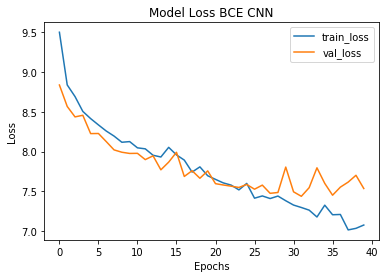

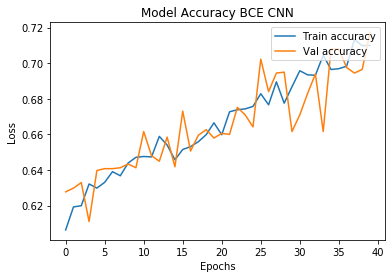

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.857868,0.677626,0.757168,0.723908,0.709632,0.717414
Confirmed,0.569132,0.791356,0.662095,0.723908,0.709632,0.717414


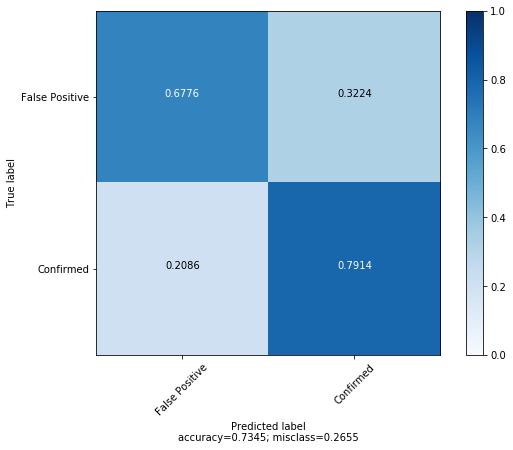

In [30]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/60
4339/4339 [==============================] - 0s 106us/step - loss: 7.0203 - acc: 0.7094 - val_loss: 7.7121 - val_acc: 0.7247
Epoch 2/60
4339/4339 [==============================] - 0s 103us/step - loss: 6.9876 - acc: 0.7096 - val_loss: 7.5963 - val_acc: 0.7096
Epoch 3/60
4339/4339 [==============================] - 0s 112us/step - loss: 6.8592 - acc: 0.7274 - val_loss: 7.5223 - val_acc: 0.7059
Epoch 4/60
4339/4339 [==============================] - 0s 111us/step - loss: 6.8765 - acc: 0.7274 - val_loss: 7.6316 - val_acc: 0.7049
Epoch 5/60
4339/4339 [==============================] - 0s 105us/step - loss: 6.8008 - acc: 0.7211 - val_loss: 7.6271 - val_acc: 0.7153
Epoch 6/60
4339/4339 [==============================] - 0s 107us/step - loss: 6.7831 - acc: 0.7370 - val_loss: 7.7833 - val_acc: 0.7372
Epoch 7/60
4339/4339 [==============================] - 0s 106us/step - loss: 6.7069 - acc: 0.7352 - val_loss: 7.6283 - val_acc: 0.7304


4339/4339 [==============================] - 0s 104us/step - loss: 3.7400 - acc: 0.8926 - val_loss: 12.6965 - val_acc: 0.7471


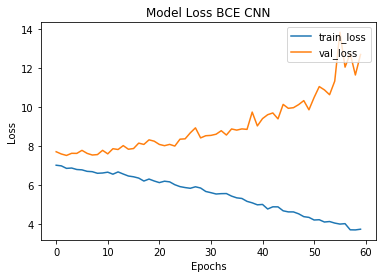

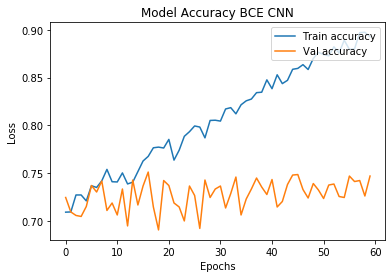

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.792178,0.828388,0.809878,0.744349,0.716223,0.747132
Confirmed,0.651466,0.596125,0.622568,0.744349,0.716223,0.747132


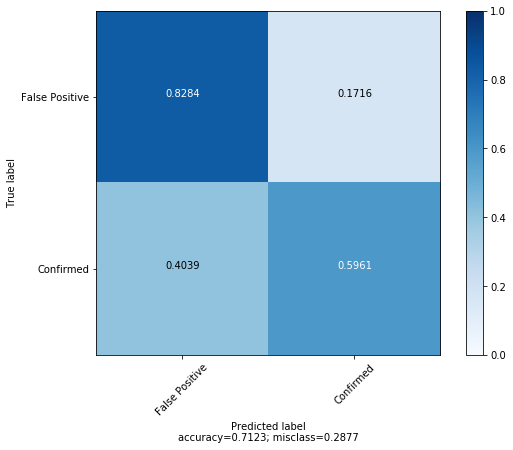

In [31]:
train_model(model, x_train, y_train, x_val, y_val, e=60)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 0s 109us/step - loss: 3.6419 - acc: 0.8961 - val_loss: 12.3070 - val_acc: 0.7456
Epoch 2/200
4339/4339 [==============================] - 0s 104us/step - loss: 3.6489 - acc: 0.8940 - val_loss: 12.7870 - val_acc: 0.7539
Epoch 3/200
4339/4339 [==============================] - 0s 106us/step - loss: 3.4120 - acc: 0.9004 - val_loss: 12.6703 - val_acc: 0.7362
Epoch 4/200
4339/4339 [==============================] - 0s 100us/step - loss: 3.2485 - acc: 0.9103 - val_loss: 12.7564 - val_acc: 0.7278
Epoch 5/200
4339/4339 [==============================] - 0s 106us/step - loss: 2.9843 - acc: 0.9230 - val_loss: 13.3227 - val_acc: 0.7237
Epoch 6/200
4339/4339 [==============================] - 0s 103us/step - loss: 3.1783 - acc: 0.9101 - val_loss: 13.6539 - val_acc: 0.7101
Epoch 7/200
4339/4339 [==============================] - 0s 105us/step - loss: 3.1458 - acc: 0.9097 - val_loss: 13.8302 - va

Epoch 60/200
4339/4339 [==============================] - 0s 107us/step - loss: 0.8755 - acc: 0.9859 - val_loss: 26.9165 - val_acc: 0.7258
Epoch 61/200
4339/4339 [==============================] - 0s 103us/step - loss: 0.7008 - acc: 0.9873 - val_loss: 26.7526 - val_acc: 0.7398
Epoch 62/200
4339/4339 [==============================] - 0s 103us/step - loss: 0.7365 - acc: 0.9873 - val_loss: 25.8635 - val_acc: 0.7273
Epoch 63/200
4339/4339 [==============================] - 0s 101us/step - loss: 0.7466 - acc: 0.9829 - val_loss: 27.0802 - val_acc: 0.7351
Epoch 64/200
4339/4339 [==============================] - 0s 103us/step - loss: 0.6270 - acc: 0.9885 - val_loss: 28.1020 - val_acc: 0.7513
Epoch 65/200
4339/4339 [==============================] - 0s 103us/step - loss: 0.5151 - acc: 0.9906 - val_loss: 28.2674 - val_acc: 0.7466
Epoch 66/200
4339/4339 [==============================] - 0s 104us/step - loss: 0.8316 - acc: 0.9813 - val_loss: 25.9924 - val_acc: 0.7310
Epoch 67/200
4339/4339 [===

Epoch 119/200
4339/4339 [==============================] - 0s 111us/step - loss: 1.0968 - acc: 0.9756 - val_loss: 34.3659 - val_acc: 0.7466
Epoch 120/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.7732 - acc: 0.9825 - val_loss: 31.8924 - val_acc: 0.7409
Epoch 121/200
4339/4339 [==============================] - 0s 113us/step - loss: 0.4647 - acc: 0.9910 - val_loss: 35.9010 - val_acc: 0.7424
Epoch 122/200
4339/4339 [==============================] - 1s 116us/step - loss: 0.3589 - acc: 0.9947 - val_loss: 36.1160 - val_acc: 0.7341
Epoch 123/200
4339/4339 [==============================] - 0s 112us/step - loss: 0.3215 - acc: 0.9933 - val_loss: 33.9091 - val_acc: 0.7419
Epoch 124/200
4339/4339 [==============================] - 0s 106us/step - loss: 0.2168 - acc: 0.9968 - val_loss: 39.2083 - val_acc: 0.7398
Epoch 125/200
4339/4339 [==============================] - 0s 106us/step - loss: 0.1153 - acc: 0.9993 - val_loss: 39.7746 - val_acc: 0.7477
Epoch 126/200
4339/4

4339/4339 [==============================] - 0s 112us/step - loss: 0.0302 - acc: 1.0000 - val_loss: 47.7877 - val_acc: 0.7320
Epoch 178/200
4339/4339 [==============================] - 1s 116us/step - loss: 0.0346 - acc: 0.9995 - val_loss: 48.1411 - val_acc: 0.7304
Epoch 179/200
4339/4339 [==============================] - 1s 115us/step - loss: 0.0372 - acc: 0.9998 - val_loss: 47.5389 - val_acc: 0.7273
Epoch 180/200
4339/4339 [==============================] - 0s 111us/step - loss: 0.2169 - acc: 0.9956 - val_loss: 39.7889 - val_acc: 0.7336
Epoch 181/200
4339/4339 [==============================] - 1s 116us/step - loss: 0.1369 - acc: 0.9975 - val_loss: 51.1932 - val_acc: 0.7284
Epoch 182/200
4339/4339 [==============================] - 0s 114us/step - loss: 0.1439 - acc: 0.9977 - val_loss: 46.9957 - val_acc: 0.7325
Epoch 183/200
4339/4339 [==============================] - 0s 113us/step - loss: 0.0672 - acc: 0.9991 - val_loss: 49.5386 - val_acc: 0.7450
Epoch 184/200
4339/4339 [=========

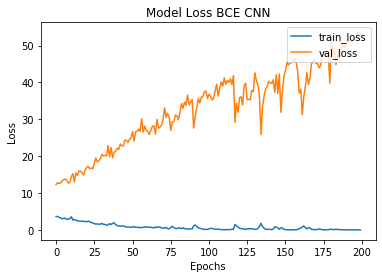

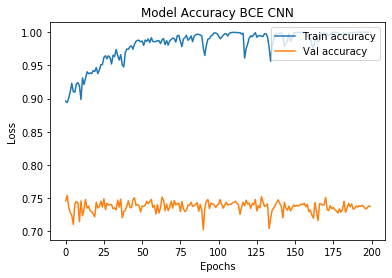

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.812974,0.773857,0.792933,0.73961,0.716723,0.737226
Confirmed,0.614227,0.669151,0.640514,0.73961,0.716723,0.737226


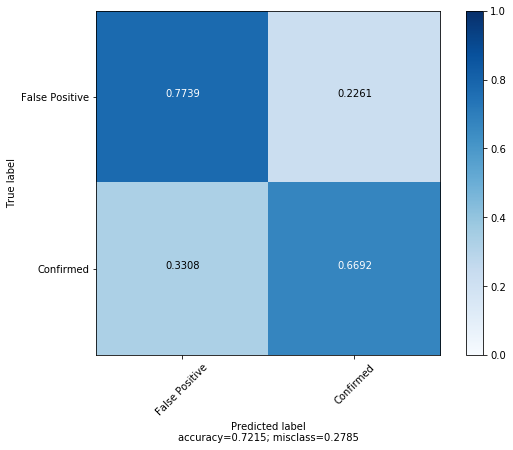

In [32]:
train_model(model, x_train, y_train, x_val, y_val, e=200) #old test

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], strides=(1, 1),activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="valid"))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss=binary_focal_loss(alpha=0.6, gamma=2),optimizer='Adam',metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               147584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

Train on 4339 samples, validate on 1918 samples
Epoch 1/40
4339/4339 [==============================] - 2s 375us/step - loss: 9.5346 - acc: 0.6128 - val_loss: 8.7555 - val_acc: 0.6257
Epoch 2/40
4339/4339 [==============================] - 0s 107us/step - loss: 8.8125 - acc: 0.6234 - val_loss: 8.5429 - val_acc: 0.6236
Epoch 3/40
4339/4339 [==============================] - 1s 145us/step - loss: 8.6242 - acc: 0.6255 - val_loss: 8.3819 - val_acc: 0.6340
Epoch 4/40
4339/4339 [==============================] - 0s 111us/step - loss: 8.5290 - acc: 0.6303 - val_loss: 8.2930 - val_acc: 0.6350
Epoch 5/40
4339/4339 [==============================] - 0s 110us/step - loss: 8.4340 - acc: 0.6294 - val_loss: 8.2304 - val_acc: 0.6288
Epoch 6/40
4339/4339 [==============================] - 1s 123us/step - loss: 8.3385 - acc: 0.6379 - val_loss: 8.1564 - val_acc: 0.6330
Epoch 7/40
4339/4339 [==============================] - 0s 99us/step - loss: 8.2766 - acc: 0.6359 - val_loss: 8.0974 - val_acc: 0.6309
E

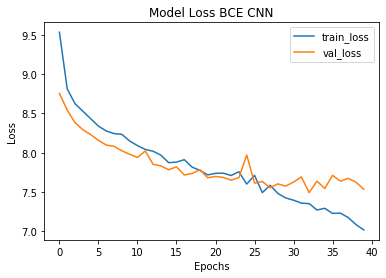

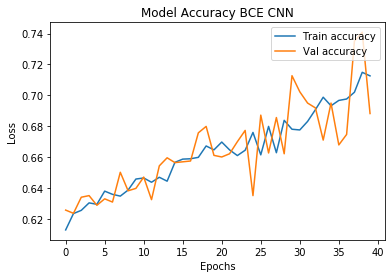

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.948824,0.550120,0.696447,0.690528,0.687988,0.688217
Confirmed,0.530544,0.944858,0.679528,0.690528,0.687988,0.688217


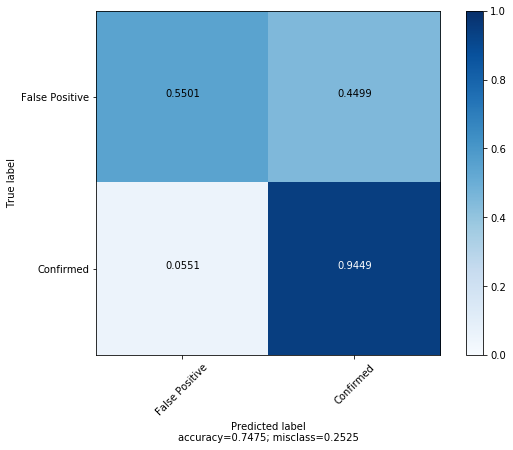

In [34]:
train_model(model, x_train, y_train, x_val, y_val, e=40)

Train on 4339 samples, validate on 1918 samples
Epoch 1/60
4339/4339 [==============================] - 0s 108us/step - loss: 7.0227 - acc: 0.7105 - val_loss: 7.6577 - val_acc: 0.7263
Epoch 2/60
4339/4339 [==============================] - 1s 148us/step - loss: 7.0587 - acc: 0.7110 - val_loss: 7.6075 - val_acc: 0.6705
Epoch 3/60
4339/4339 [==============================] - 1s 125us/step - loss: 7.0045 - acc: 0.7115 - val_loss: 7.7088 - val_acc: 0.6658
Epoch 4/60
4339/4339 [==============================] - 1s 130us/step - loss: 6.9669 - acc: 0.7133 - val_loss: 7.6599 - val_acc: 0.6966
Epoch 5/60
4339/4339 [==============================] - 0s 103us/step - loss: 7.0365 - acc: 0.7260 - val_loss: 7.7129 - val_acc: 0.7289
Epoch 6/60
4339/4339 [==============================] - 1s 124us/step - loss: 6.8719 - acc: 0.7264 - val_loss: 7.6809 - val_acc: 0.7065
Epoch 7/60
4339/4339 [==============================] - 0s 109us/step - loss: 6.9013 - acc: 0.7225 - val_loss: 8.1098 - val_acc: 0.7205


4339/4339 [==============================] - 1s 120us/step - loss: 4.0095 - acc: 0.8825 - val_loss: 11.8233 - val_acc: 0.7565


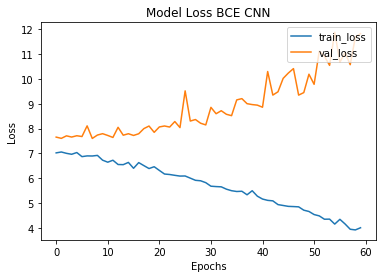

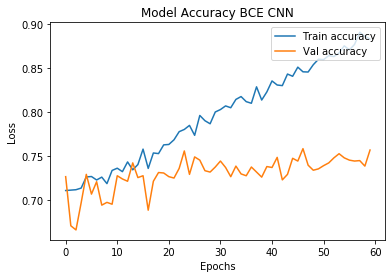

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.818627,0.803528,0.811008,0.757435,0.734442,0.756517
Confirmed,0.646974,0.669151,0.657875,0.757435,0.734442,0.756517


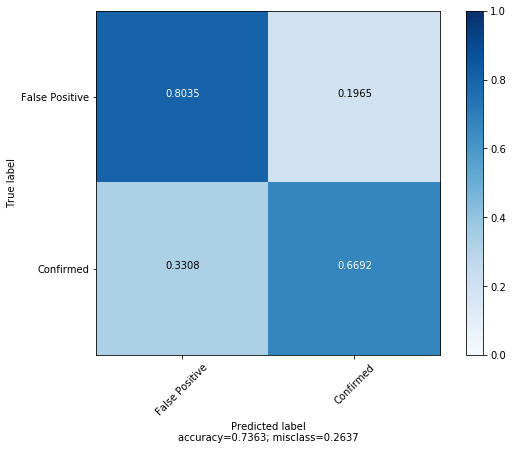

In [35]:
train_model(model, x_train, y_train, x_val, y_val, e=60)

Train on 4339 samples, validate on 1918 samples
Epoch 1/200
4339/4339 [==============================] - 1s 117us/step - loss: 3.7114 - acc: 0.8972 - val_loss: 11.7368 - val_acc: 0.7487
Epoch 2/200
4339/4339 [==============================] - 0s 115us/step - loss: 3.7924 - acc: 0.8894 - val_loss: 11.1466 - val_acc: 0.7216
Epoch 3/200
4339/4339 [==============================] - 1s 136us/step - loss: 3.8806 - acc: 0.8850 - val_loss: 11.9453 - val_acc: 0.7596
Epoch 4/200
4339/4339 [==============================] - 1s 116us/step - loss: 3.5530 - acc: 0.9000 - val_loss: 12.2969 - val_acc: 0.7503
Epoch 5/200
4339/4339 [==============================] - 0s 106us/step - loss: 3.4736 - acc: 0.9027 - val_loss: 12.2620 - val_acc: 0.7372
Epoch 6/200
4339/4339 [==============================] - 0s 111us/step - loss: 3.4383 - acc: 0.9030 - val_loss: 12.1432 - val_acc: 0.7299
Epoch 7/200
4339/4339 [==============================] - 1s 118us/step - loss: 3.4454 - acc: 0.8977 - val_loss: 11.7109 - va

4339/4339 [==============================] - 1s 120us/step - loss: 0.9146 - acc: 0.9799 - val_loss: 25.0527 - val_acc: 0.7518
Epoch 60/200
4339/4339 [==============================] - 0s 113us/step - loss: 0.7716 - acc: 0.9859 - val_loss: 25.0947 - val_acc: 0.7461
Epoch 61/200
4339/4339 [==============================] - 0s 110us/step - loss: 0.6714 - acc: 0.9885 - val_loss: 26.4977 - val_acc: 0.7602
Epoch 62/200
4339/4339 [==============================] - 1s 115us/step - loss: 0.7446 - acc: 0.9864 - val_loss: 24.5551 - val_acc: 0.7456
Epoch 63/200
4339/4339 [==============================] - 0s 110us/step - loss: 0.7411 - acc: 0.9848 - val_loss: 25.7506 - val_acc: 0.7518
Epoch 64/200
4339/4339 [==============================] - 1s 134us/step - loss: 0.5461 - acc: 0.9910 - val_loss: 25.0498 - val_acc: 0.7450
Epoch 65/200
4339/4339 [==============================] - 1s 118us/step - loss: 0.6601 - acc: 0.9869 - val_loss: 27.3275 - val_acc: 0.7612
Epoch 66/200
4339/4339 [================

Epoch 118/200
4339/4339 [==============================] - 0s 105us/step - loss: 0.1321 - acc: 0.9984 - val_loss: 37.4886 - val_acc: 0.7581
Epoch 119/200
4339/4339 [==============================] - 1s 119us/step - loss: 0.1323 - acc: 0.9984 - val_loss: 36.8019 - val_acc: 0.7445
Epoch 120/200
4339/4339 [==============================] - 0s 104us/step - loss: 0.1021 - acc: 0.9988 - val_loss: 38.7933 - val_acc: 0.7581
Epoch 121/200
4339/4339 [==============================] - 0s 112us/step - loss: 0.1216 - acc: 0.9991 - val_loss: 37.1651 - val_acc: 0.7482
Epoch 122/200
4339/4339 [==============================] - 1s 123us/step - loss: 0.1221 - acc: 0.9988 - val_loss: 38.6092 - val_acc: 0.7539
Epoch 123/200
4339/4339 [==============================] - 1s 116us/step - loss: 0.1310 - acc: 0.9984 - val_loss: 39.0346 - val_acc: 0.7539
Epoch 124/200
4339/4339 [==============================] - 1s 122us/step - loss: 0.1781 - acc: 0.9965 - val_loss: 37.5823 - val_acc: 0.7550
Epoch 125/200
4339/4

4339/4339 [==============================] - 0s 100us/step - loss: 0.0594 - acc: 1.0000 - val_loss: 38.6570 - val_acc: 0.7445
Epoch 177/200
4339/4339 [==============================] - 1s 121us/step - loss: 0.0427 - acc: 1.0000 - val_loss: 39.9198 - val_acc: 0.7471
Epoch 178/200
4339/4339 [==============================] - 1s 122us/step - loss: 0.0552 - acc: 0.9995 - val_loss: 39.4653 - val_acc: 0.7503
Epoch 179/200
4339/4339 [==============================] - 0s 112us/step - loss: 0.0435 - acc: 1.0000 - val_loss: 40.5110 - val_acc: 0.7508
Epoch 180/200
4339/4339 [==============================] - 1s 136us/step - loss: 0.0401 - acc: 1.0000 - val_loss: 40.7079 - val_acc: 0.7492
Epoch 181/200
4339/4339 [==============================] - 1s 121us/step - loss: 0.0324 - acc: 1.0000 - val_loss: 41.5693 - val_acc: 0.7550
Epoch 182/200
4339/4339 [==============================] - 1s 126us/step - loss: 0.0351 - acc: 1.0000 - val_loss: 41.5628 - val_acc: 0.7518
Epoch 183/200
4339/4339 [=========

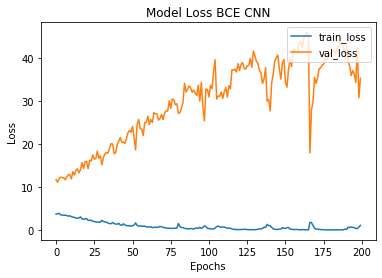

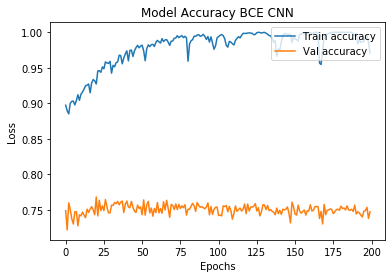

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.815397,0.789896,0.802444,0.748694,0.725625,0.747132
Confirmed,0.630986,0.667660,0.648805,0.748694,0.725625,0.747132


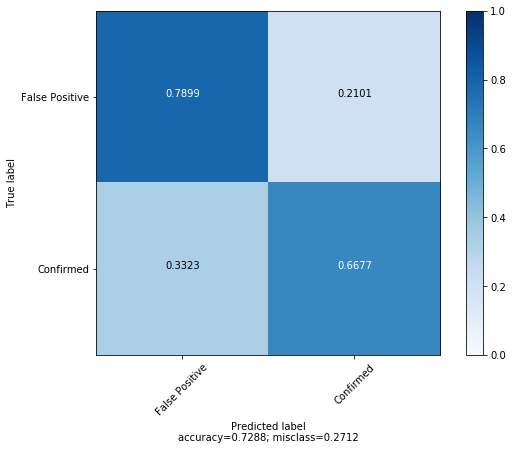

In [36]:
train_model(model, x_train, y_train, x_val, y_val, e=200)